In [71]:
import cv2
import math
import matplotlib.pyplot as plt
import moviepy.editor
from moviepy.editor import VideoFileClip
from moviepy.video.tools.tracking import manual_tracking
import numpy as np
import os
import pims
from pims import Frame
import pygame

In [77]:
def getPoints(data1, data2, data3, frameRate):
    
    times = []          # time stamps of video's frames
    x1a = []
    y1a = []
    x2a = []
    y2a = []
    x1b = []
    y1b = []
    x2b = []
    y2b = []
    
    # Create variables to be used/editted displaying position selections and/or computing splay angles
    counter = 0          # variable used to iterate over video's frames
    
    # Loop over all lines in txt file - nth (non-empty) line corresponds to data from nth frame of video
    for line in data1.readlines():
        iData1 = line.split()          # divide line into individual values for time stamp and corner positions
        if iData1[0].isdigit() == True:
            times.append(int(iData1[0])/1000*(video.fps/frameRate))          # time stamp
            x1a.append(int(iData1[1]))          # vertex x-position
            y1a.append(int(iData1[2]))          # vertex y-position
    
    for line in data2.readlines():
        iData2 = line.split()
        if iData2[0].isdigit() == True:
            x2a.append(int(iData2[1]))          # vertex x-position
            y2a.append(int(iData2[2]))          # vertex y-position
            x1b.append(int(round(int(iData2[1])/4)))          # vertex x-position
            y1b.append(int(round(int(iData2[2])/4)))          # vertex y-position
    
    for line in data3.readlines():
        iData3 = line.split()
        if iData3[0].isdigit() == True:
            x2b.append(int(round(int(iData3[1])/4)))          # vertex x-position
            y2b.append(int(round(int(iData3[2])/4)))          # vertex y-position
    
    return(times, x1a, y1a, x2a, y2a, x1b, y1b, x2b, y2b)




def ckds(images, times, x1, y1, x2, y2):
    
    lengths = []          # splay angle values
    counter = 0          # variable used to iterate over video's frames
    
    for i in range(len(times)):
        
        #lengths.append(math.sqrt((x1[i]-x2[i])**2+(y1[i]-y2[i])**2))          # one vertex-end side
        lengths.append(math.sqrt((x1[i]-x2[i])**2+(y1[i]-y2[i])**2)/49.4576)          # one vertex-end side
        
        frame = cv2.resize(images[counter], None, fx=4, fy=4, interpolation=cv2.INTER_CUBIC)        # enlarge image of frame
        cv2.circle(frame, (x1[i],y1[i]), 4, (0,0,0), -1)          # dot on vertex
        cv2.circle(frame, (x2[i],y2[i]), 4, (0,0,0), -1)          # dot on one end
        
        cv2.imshow('Frames', frame)          # display image
        cv2.waitKey(1000)          # holds image until x-ed out of window
        cv2.destroyAllWindows()          # clear image to make way for next frame
        
        counter += 1          # iterate to next frame
    
    return(lengths)




def labelStub(imagesAdj, x1, y1, x2, y2):
    
    vidL = len(imagesAdj)
    vidH = len(imagesAdj[0])
    vidW = len(imagesAdj[0][0])
    
    stubIms = []
    edges = []
    edgeIms = []
    
    for i in range(vidL):
        
        x1i = x1[i]
        y1i = y1[i]
        x2i = x2[i]
        y2i = y2[i]
        
        imageI = imagesAdj[i]
        stubImI = np.zeros((vidH, vidW))
        edgesI = []
        edgeImI = np.zeros((vidH, vidW))
        x = x2i-x1i
        y = y2i-y1i
        
        if abs(x)>abs(y):
            
            if x1i < x2i:
                xLow = x1i
                xHigh = x2i
            else:
                xLow = x2i
                xHigh = x1i
            
            for k in range(0, xLow):
                for j in range(vidH):
                    edgeImI[j][k] = imageI[j][k]
            
            for k in range(xLow, xHigh+1):
                startJ = 0
                endJ = vidH-1
                K = k-x1i
                for j in range(vidH):
                    edgeImI[j][k] = imageI[j][k]
                    J = j-y1i
                    inRT = (y**4+x**2*y**2)*K**2+(x**4+x**2*y**2)*J**2-2*x*y*(x**2+y**2)*K*J
                    if inRT == 0:
                        L = 0
                    else:
                        L = math.sqrt(inRT)/(x**2+y**2)
                    if L < 2.5:
                        stubImI[j][k] = 1
                        if startJ == 0:
                            startJ = j
                        endJ = j
                edgesI.append([startJ,endJ])
                edgeImI[startJ][k] = 65535
                edgeImI[endJ][k] = 65535
            
            for k in range(xHigh+1, vidW):
                for j in range(vidH):
                    edgeImI[j][k] = imageI[j][k]
        
        else:
            
            if y1i < y2i:
                yLow = y1i
                yHigh = y2i
            else:
                yLow = y2i
                yHigh = y1i
            
            for j in range(0, yLow):
                for k in range(vidW):
                    edgeImI[j][k] = imageI[j][k]
            
            for j in range(yLow, yHigh+1):
                startK = 0
                endK = vidW-1
                J = j-y1i
                for k in range(vidW):
                    edgeImI[j][k] = imageI[j][k]
                    K = k-x1i
                    inRT = (y**4+x**2*y**2)*K**2+(x**4+x**2*y**2)*J**2-2*x*y*(x**2+y**2)*K*J
                    if inRT == 0:
                        L = 0
                    else:
                        L = math.sqrt(inRT)/(x**2+y**2)
                    if L < 2.5:
                        stubImI[j][k] = 1
                        if startK == 0:
                            startK = k
                        endK = k
                edgesI.append([startK,endK])
                edgeImI[j][startK] = 65535
                edgeImI[j][endK] = 65535
            
            for j in range(yHigh+1, vidH):
                for k in range(vidW):
                    edgeImI[j][k] = imageI[j][k]
        
        stubIms.append(stubImI)
        edges.append(edgesI)
        edgeIms.append(edgeImI)
    
    return(stubIms, edges, edgeIms)




def intensities(images, stubIms):
    
    vidL = len(images)
    vidH = len(images[0])
    vidW = len(images[0][0])
    
    avgImIs = []
    stubIs = []
    avgIs = []
    normIs = []
    
    for i in range(vidL):
        
        stubIsI = []
        imageI = images[i]
        stubImI = stubIms[i]
        
        for j in range(vidH):
            for k in range(vidW):
                if stubImI[j][k] == 1:
                    stubIsI.append(imageI[j][k])
        
        avgImI = np.mean(imageI)
        avgStubI = np.mean(stubIsI)
        avgImIs.append(avgImI)
        stubIs.append(stubIsI)
        avgIs.append(avgStubI)
        normIs.append(avgStubI/avgImI)
    
    return(avgImIs, stubIs, avgIs, normIs)




def smoothenFiberData(smoothLengths, order):
    
    smoothLengths.clear()
    smoothen = []
    counter = 0
    
    for i in range(len(lengths)):
        
        smoothLengths.append(lengths[i])
    
    while counter<order:
                
        smoothL0 = (20*smoothLengths[0] + 15*smoothLengths[1] + 6*smoothLengths[2] + smoothLengths[3])/42
        smoothL1 = (15*smoothLengths[0] + 20*smoothLengths[1] + 15*smoothLengths[2] + 6*smoothLengths[3] + smoothLengths[4])/57
        smoothL2 = (6*smoothLengths[0] + 15*smoothLengths[1] + 20*smoothLengths[2] + 15*smoothLengths[3] + 6*smoothLengths[4] + smoothLengths[5])/63
        
        smoothen.append(smoothL0)
        smoothen.append(smoothL1)
        smoothen.append(smoothL2)
        
        for i in range(3,len(smoothLengths)-3):
            
            smoothLI = (smoothLengths[i-3] + 6*smoothLengths[i-2] + 15*smoothLengths[i-1] + 20*smoothLengths[i] + 15*smoothLengths[i+1] + 6*smoothLengths[i+2] + smoothLengths[i+3])/64
            smoothen.append(smoothLI)
        
        smoothLM2 = (smoothLengths[len(lengths)-6] + 6*smoothLengths[len(lengths)-5] + 15*smoothLengths[len(lengths)-4] + 20*smoothLengths[len(lengths)-3] + 15*smoothLengths[len(lengths)-2] + 6*smoothLengths[len(lengths)-1])/63
        smoothLM1 = (smoothLengths[len(lengths)-5] + 6*smoothLengths[len(lengths)-4] + 15*smoothLengths[len(lengths)-3] + 20*smoothLengths[len(lengths)-2] + 15*smoothLengths[len(lengths)-1])/57
        smoothLM0 = (smoothLengths[len(lengths)-4] + 6*smoothLengths[len(lengths)-3] + 15*smoothLengths[len(lengths)-2] + 20*smoothLengths[len(lengths)-1])/42
        
        smoothen.append(smoothLM2)
        smoothen.append(smoothLM1)
        smoothen.append(smoothLM0)
        
        smoothLengths.clear()
        
        for i in range(len(smoothen)):
            
            smoothLengths.append(smoothen[i])
        
        smoothen.clear()
        counter += 1
        
    return smoothLengths




def writeFileCKD(name, times, stubIs):
    
    newFile = open(name,'w')          # Create txt file with video-specific name
    
    # List the video's timestamps
    newFile.write('Timestamps (s)\n')
    for i in range(len(times)):
        newFile.write('{}\n'.format(times[i]))
    
    newFile.write('\n')          # skip a line
    
    # List the measured CKDs
    newFile.write('Centrosome-Kinetochore Distances (pixels)\n')
    for i in range(len(lengths)):
        newFile.write('{}\n'.format(lengths[i]))
    
    newFile.close()
    
    return()




def writeFileSI(name, times, avgIs, normIs):
    
    newFile = open(name,'w')          # Create txt file with video-specific name
    
    # List the video's timestamps
    newFile.write('Timestamps (s)\n')
    for i in range(len(times)):
        newFile.write('{}\n'.format(times[i]))
    
    newFile.write('\n')          # skip a line
    
    # List the measured splay angles
    newFile.write('Average Stub Intensity (au)\n')
    for i in range(len(avgIs)):
        newFile.write('{}\n'.format(avgIs[i]))
    
    newFile.write('\n')          # skip a line
    
    # List the measured splay angles
    newFile.write('Normalized Average Stub Intensity (au)\n')
    for i in range(len(normIs)):
        newFile.write('{}\n'.format(normIs[i]))
    
    newFile.close()
    
    return()

In [166]:
video = VideoFileClip(r'E:\KFiberSplaying\AblationExperiments\IntermediateVids\NewClips\R1_fiber.avi').resize(4)
images = pims.open(r'E:\KFiberSplaying\AblationExperiments\IntermediateVids\NewClips\R1_fiber_original.tif')
imagesAdj = pims.open(r'E:\KFiberSplaying\AblationExperiments\IntermediateVids\NewClips\R1_fiber.tif')

In [167]:
frameRate = 1/3.5         # frames/s for video IN REAL TIME (while imaging on the scope)
frames = video.duration*video.fps          # number of frames in video
duration = frames/frameRate          # duration of video IN REAL TIME (while imaging on the scope)

print(frameRate, frames, duration, video.fps)

0.2857142857142857 23.03 80.605 7.0


In [168]:
# Track centrosome
manual_tracking(video, t1=0, t2=video.end, fps=video.fps, nobjects=1, savefile='R1_fiber_track1.txt')          # tracks stub's corners
pygame.quit()          # closes display window

# Track plus-end
manual_tracking(video, t1=0, t2=video.end, fps=video.fps, nobjects=1, savefile='R1_fiber_track2.txt')          # tracks stub's corners
pygame.quit()          # closes display window

# Track minus-end
manual_tracking(video, t1=0, t2=video.end, fps=video.fps, nobjects=1, savefile='R1_fiber_track3.txt')          # tracks stub's corners
pygame.quit()          # closes display window

In [169]:
data1 = open('R1_fiber_track1.txt')          # load txt file containing the manual_tracking output data for stub corner positions
data2 = open('R1_fiber_track2.txt')
data3 = open('R1_fiber_track3.txt')

times, x1a, y1a, x2a, y2a, x1b, y1b, x2b, y2b = getPoints(data1, data2, data3, frameRate)
lengths = ckds(imagesAdj, times, x1a, y1a, x2a, y2a)
stubIms, edges, edgeIms = labelStub(imagesAdj, x1b, y1b, x2b, y2b)
avgImIs, stubIs, avgIs, normIs = intensities(images, stubIms)
writeFileCKD('R1_fiber.txt', times, lengths)
writeFileSI('R1_stubIs.txt', times, avgIs, normIs)

()

Text(0, 0.5, 'CKD ($\\mu m$)')

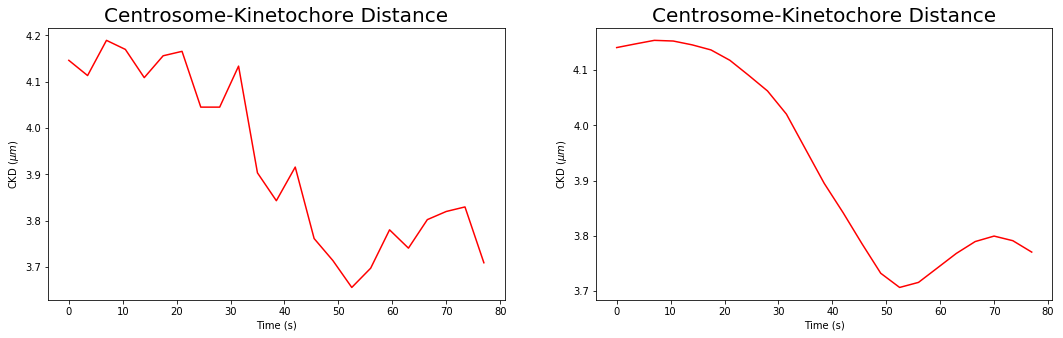

In [170]:
smoothLengths = []
smoothFiber1 = smoothenFiberData(smoothLengths, 1)

fig = plt.figure(figsize=[18,5])

fig.add_subplot(1,2,1)
plt.plot(times, lengths, '-r')          # create plot
plt.title('Centrosome-Kinetochore Distance', fontsize=20)          # plot title
plt.xlabel('Time (s)')          # label x-axis
plt.ylabel('CKD ($\mu m$)')          # label y-axis

fig.add_subplot(1,2,2)
plt.plot(times, smoothFiber1, '-r')          # create plot
plt.title('Centrosome-Kinetochore Distance', fontsize=20)          # plot title
plt.xlabel('Time (s)')          # label x-axis
plt.ylabel('CKD ($\mu m$)')          # label y-axis

Text(0, 0.5, 'Intensity (au)')

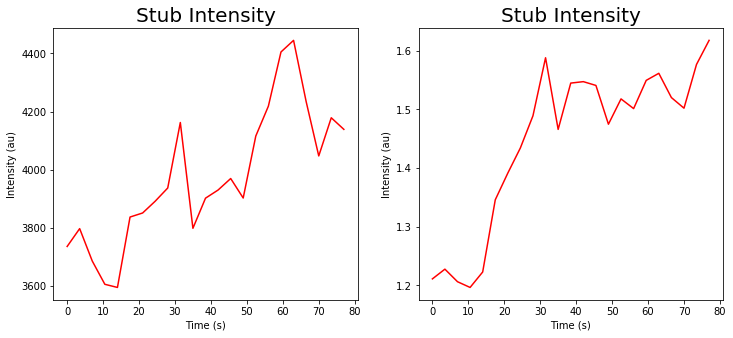

In [171]:
fig = plt.figure(figsize=[12,5])

fig.add_subplot(1,2,1)
plt.plot(times, avgIs, '-r')          # create plot
plt.title('Stub Intensity', fontsize=20)          # plot title
plt.xlabel('Time (s)')          # label x-axis
plt.ylabel('Intensity (au)')          # label y-axis

fig.add_subplot(1,2,2)
plt.plot(times, normIs, '-r')          # create plot
plt.title('Stub Intensity', fontsize=20)          # plot title
plt.xlabel('Time (s)')          # label x-axis
plt.ylabel('Intensity (au)')          # label y-axis

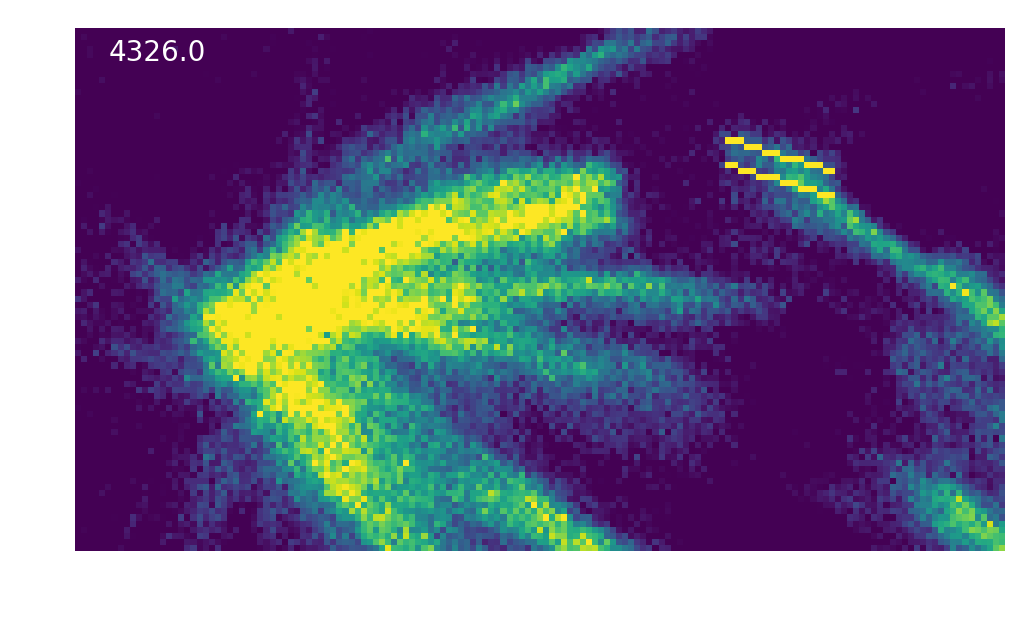

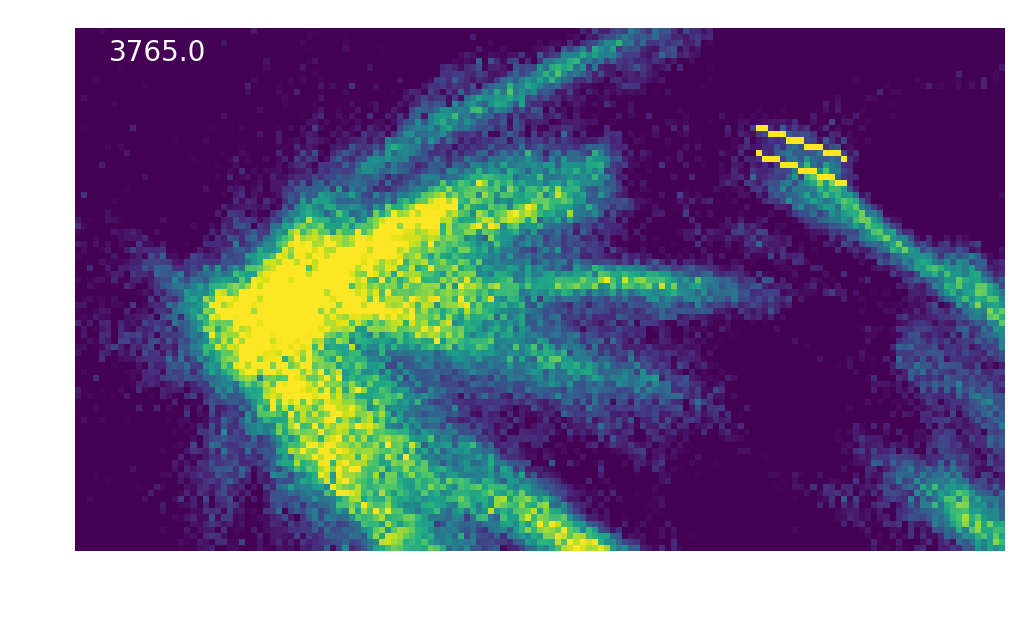

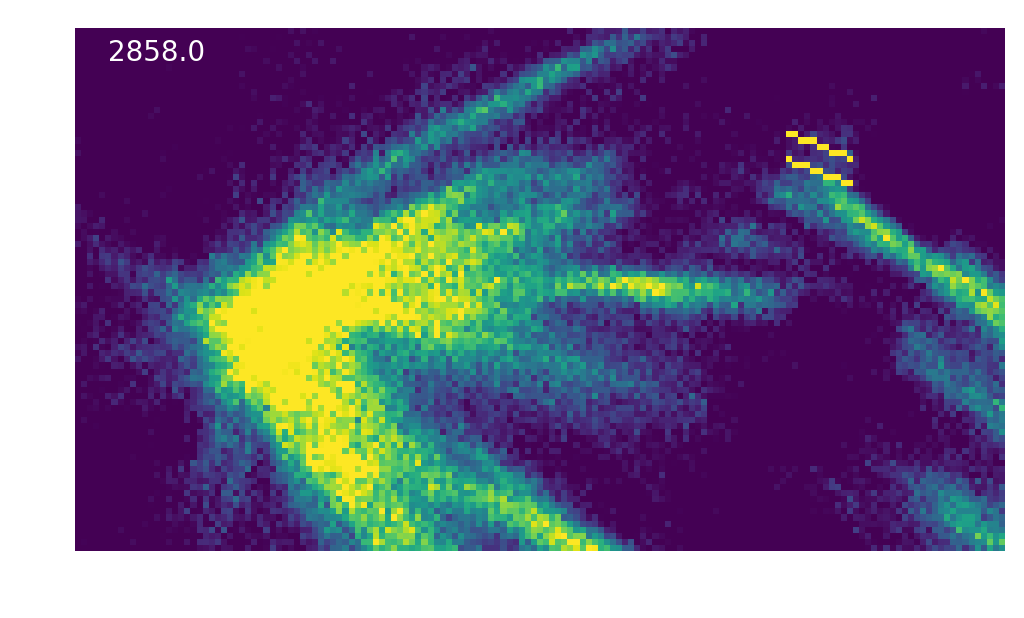

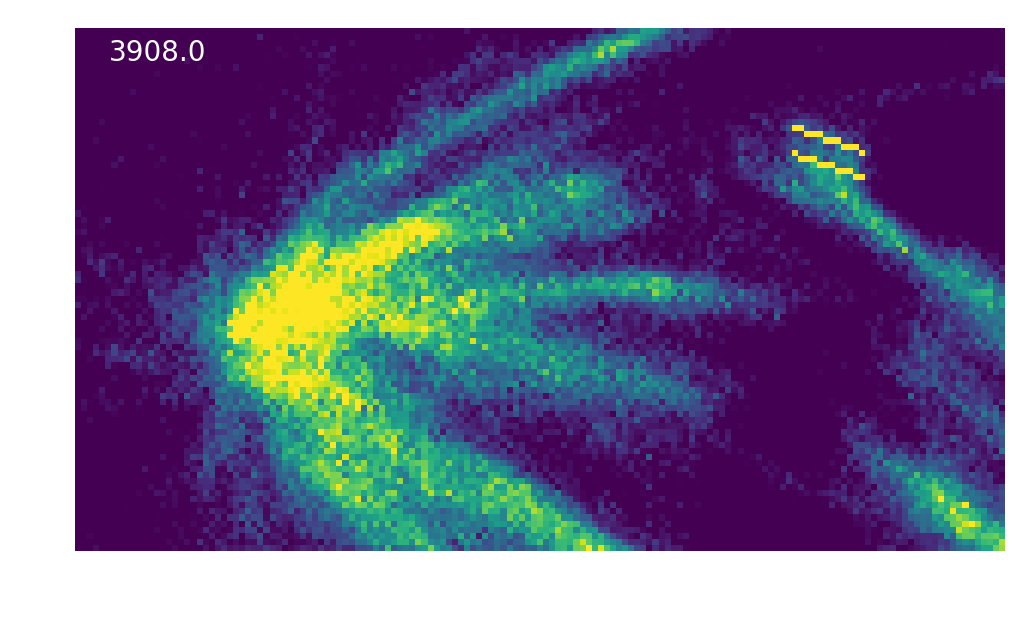

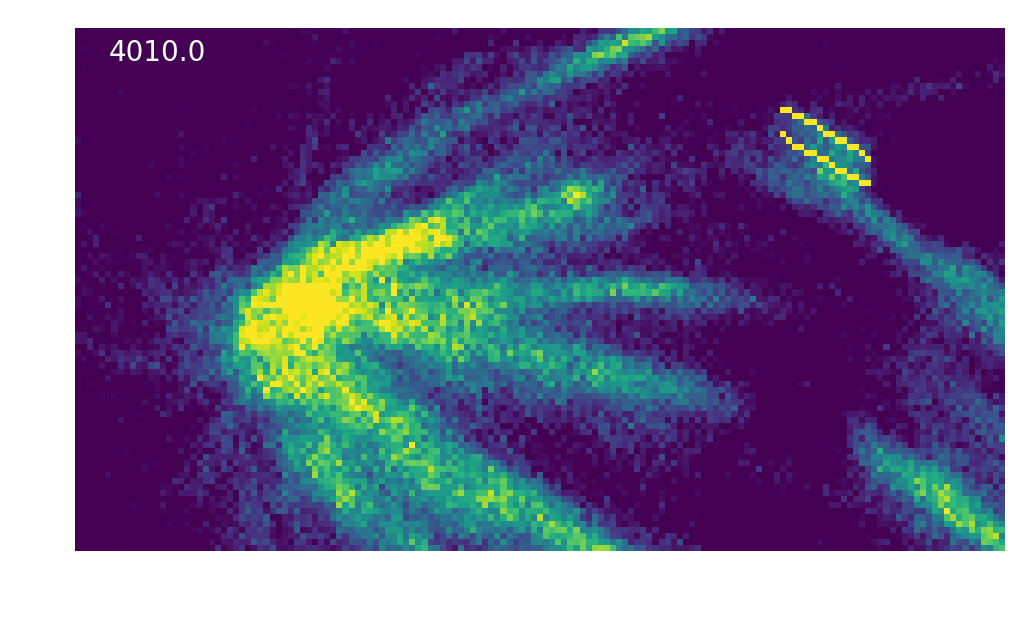

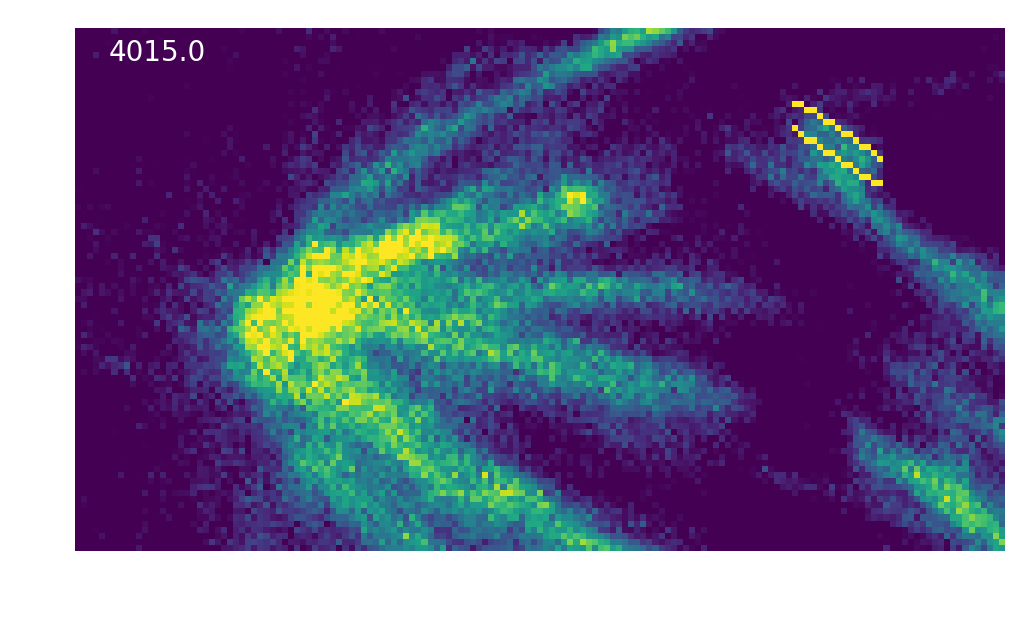

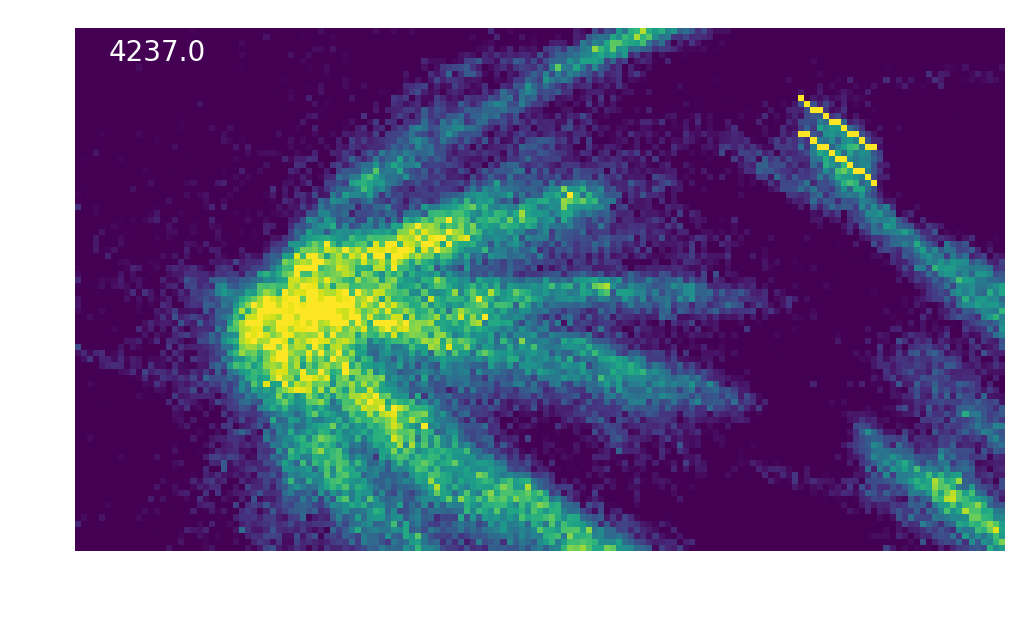

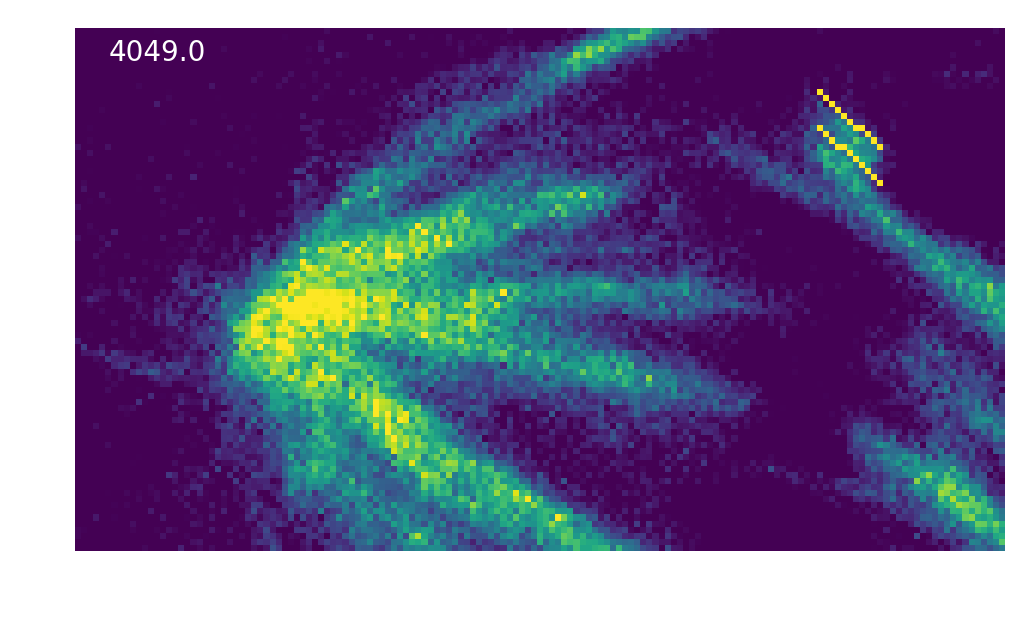

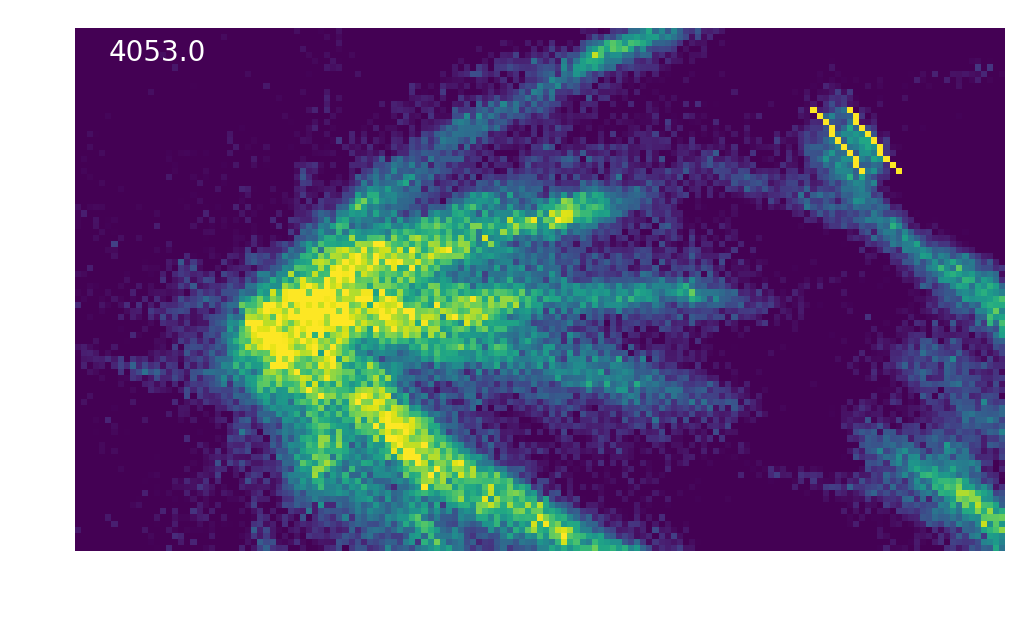

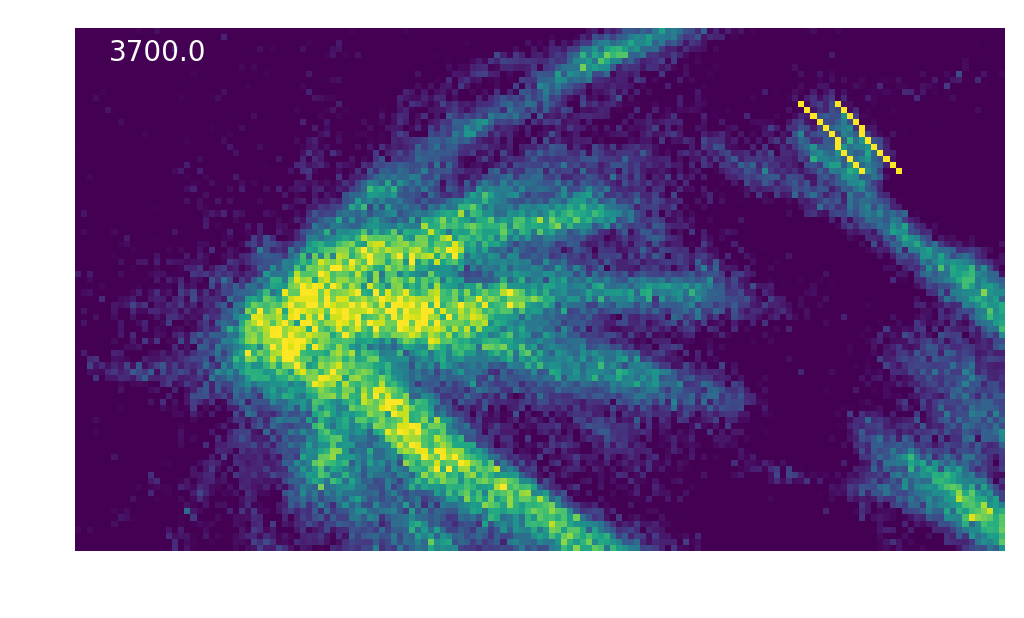

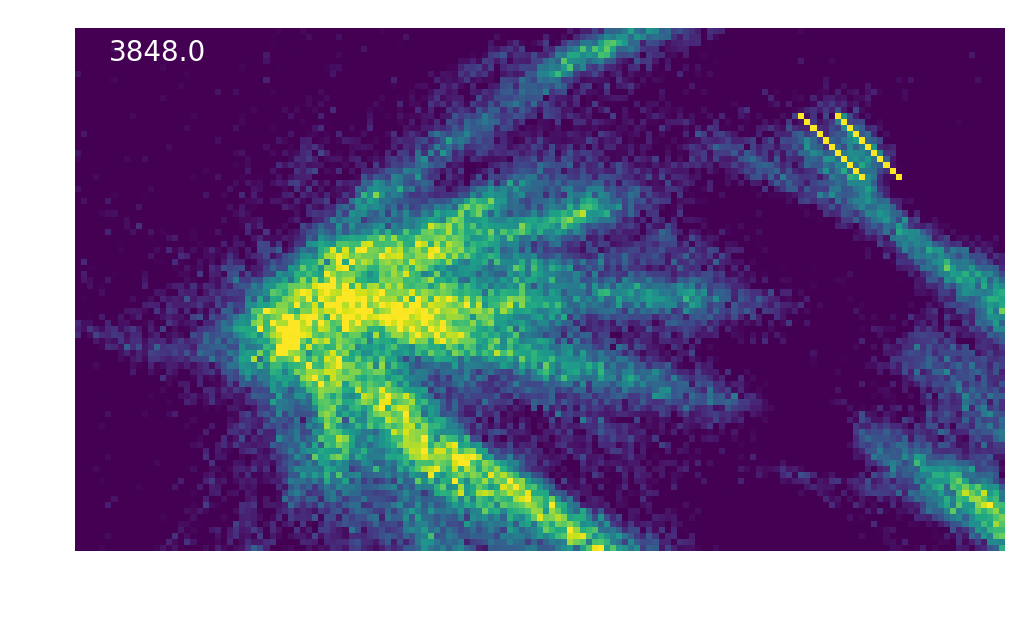

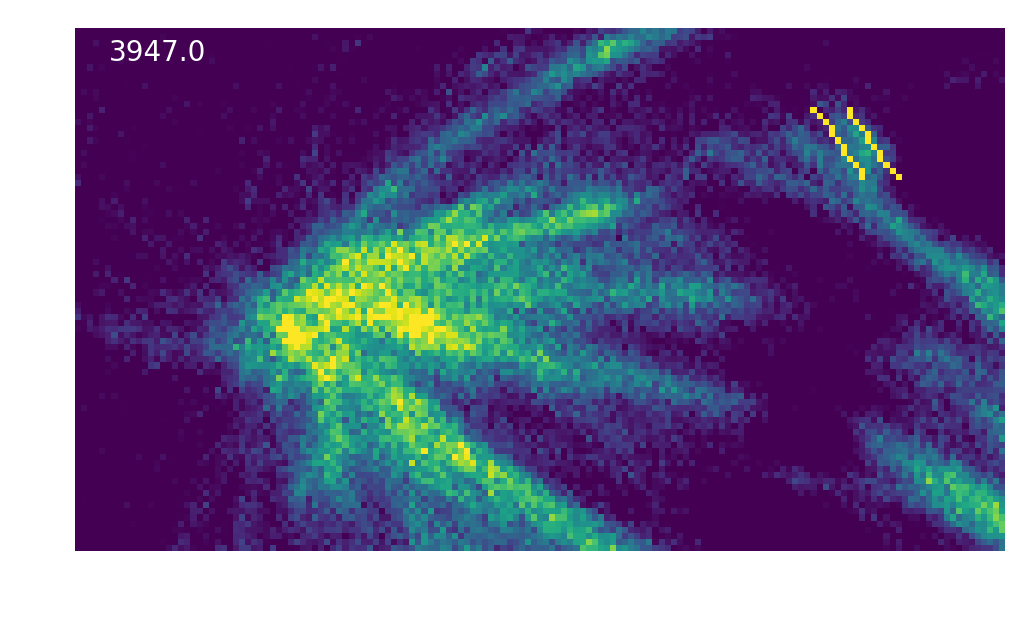

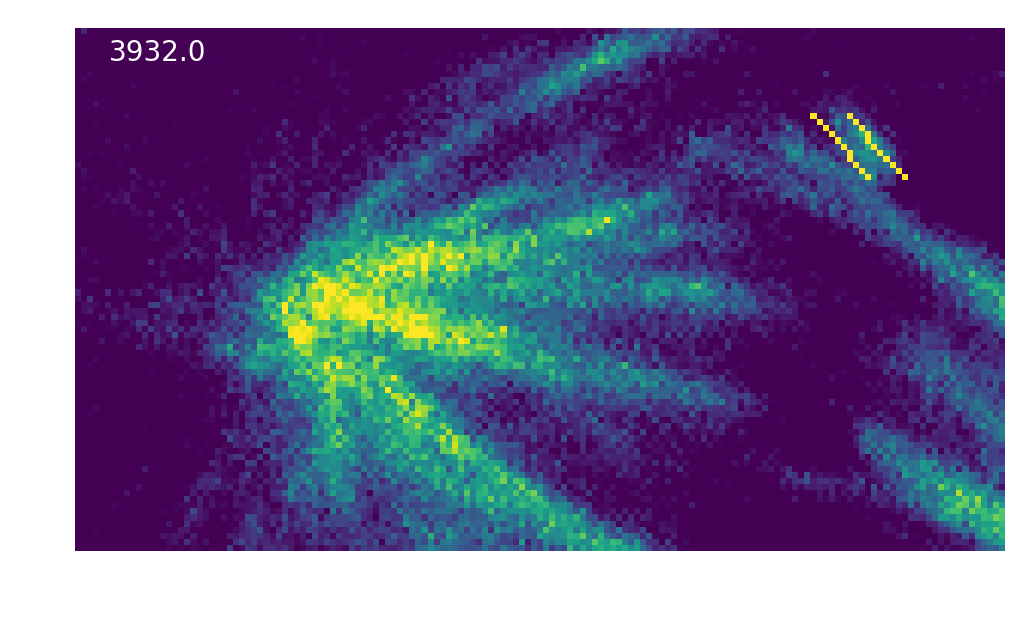

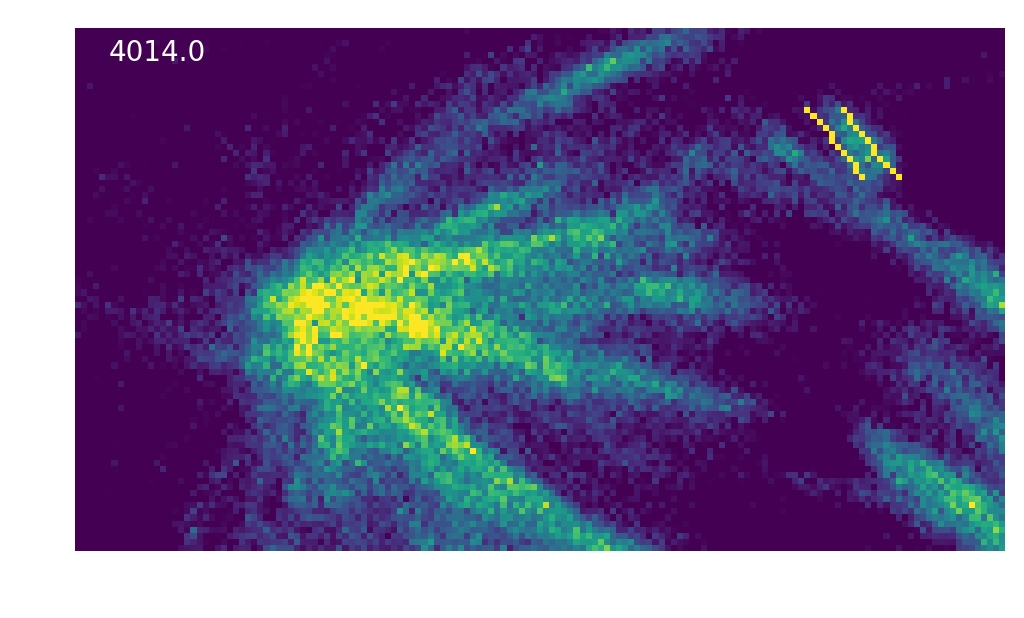

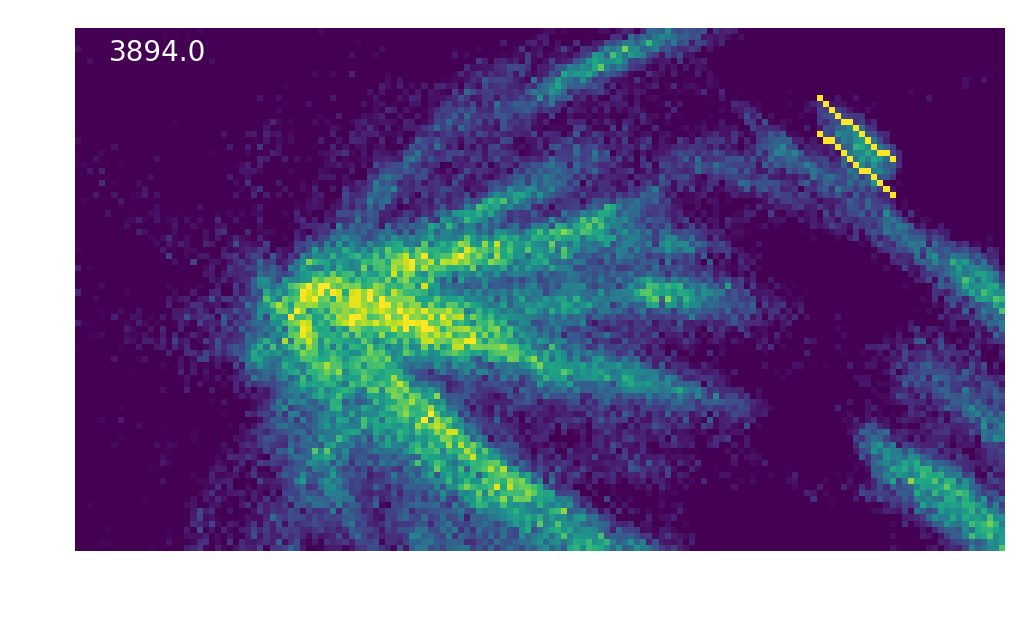

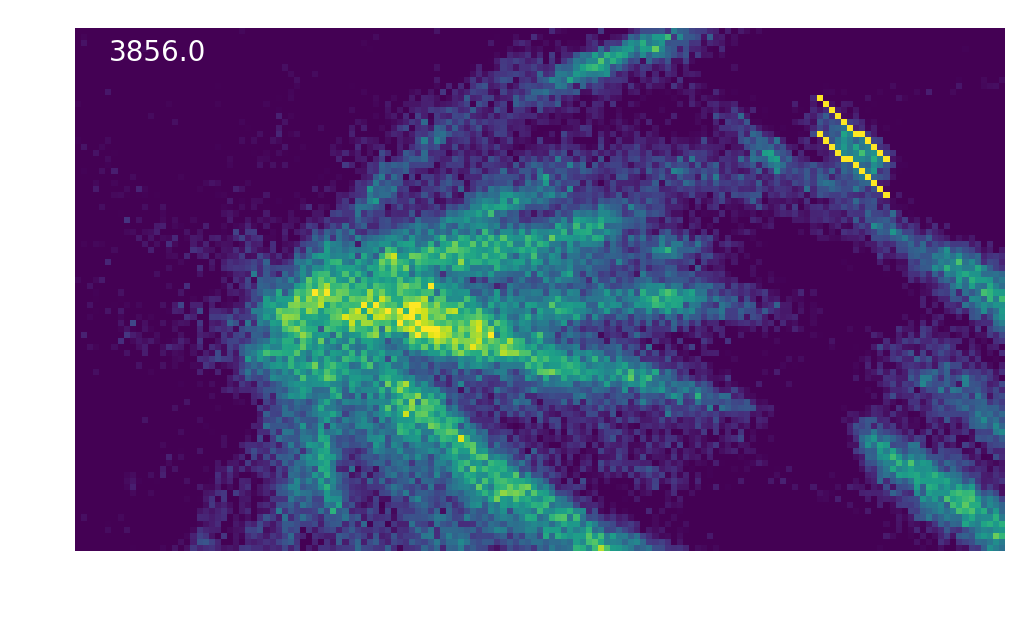

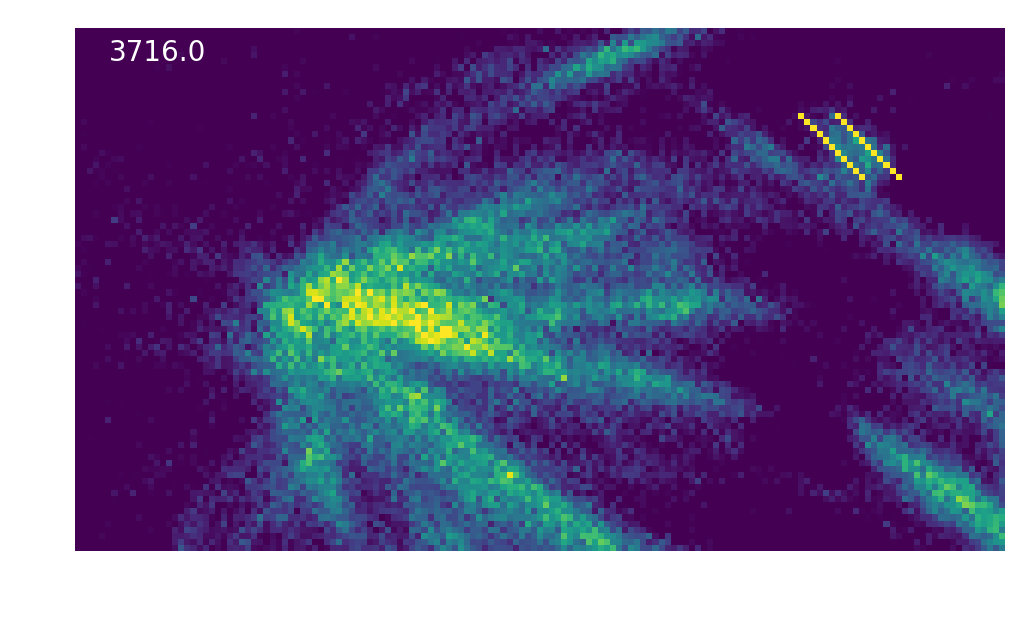

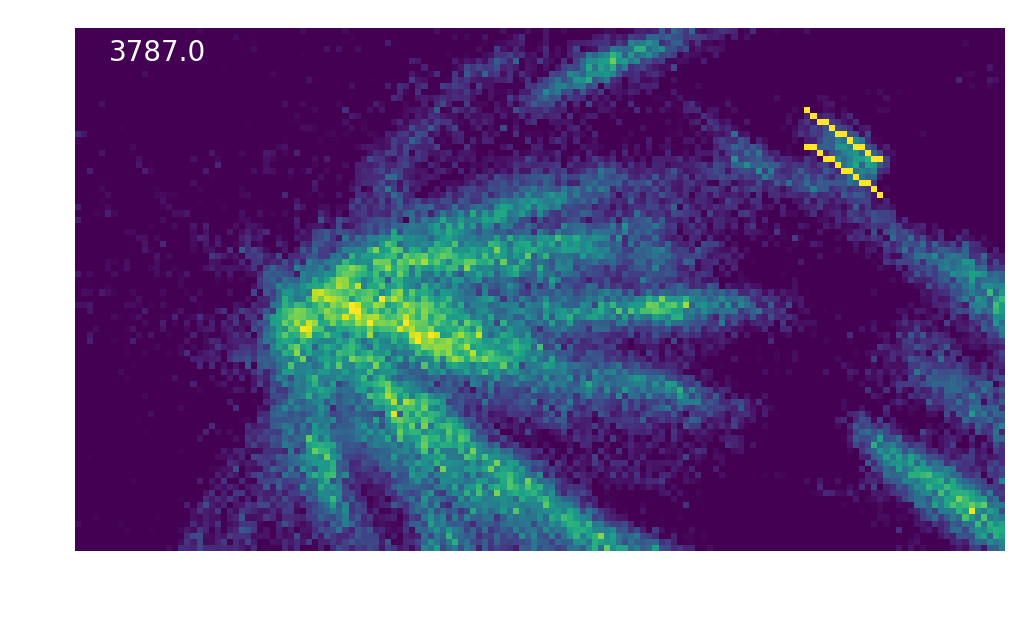

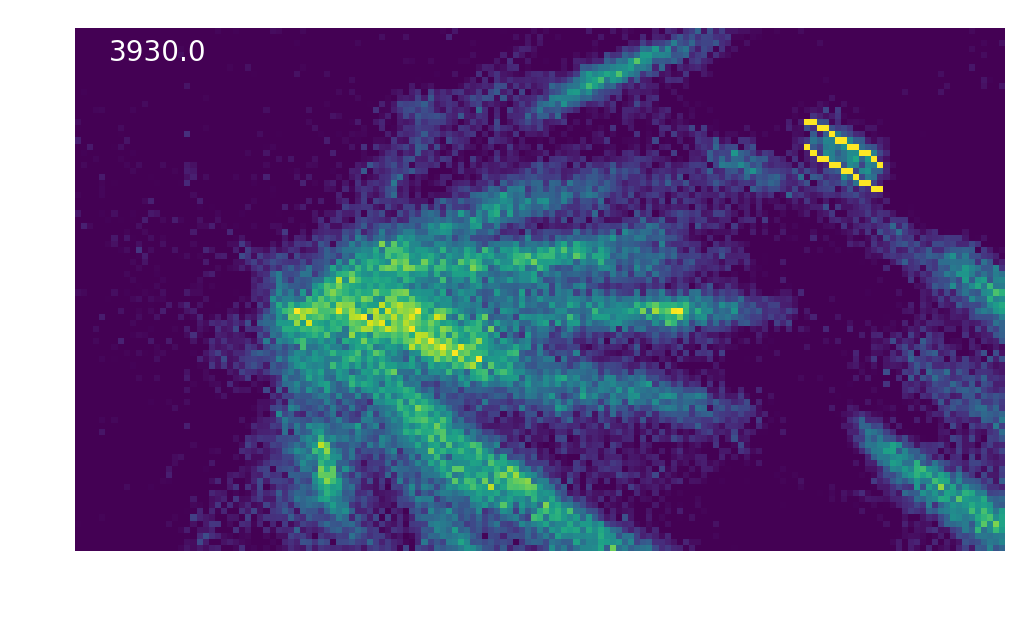

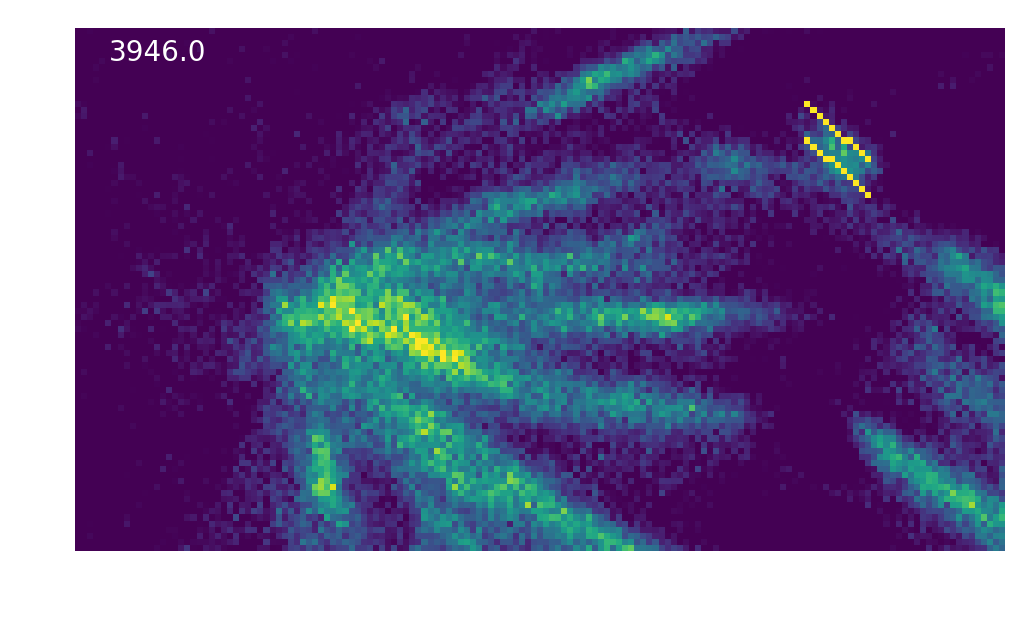

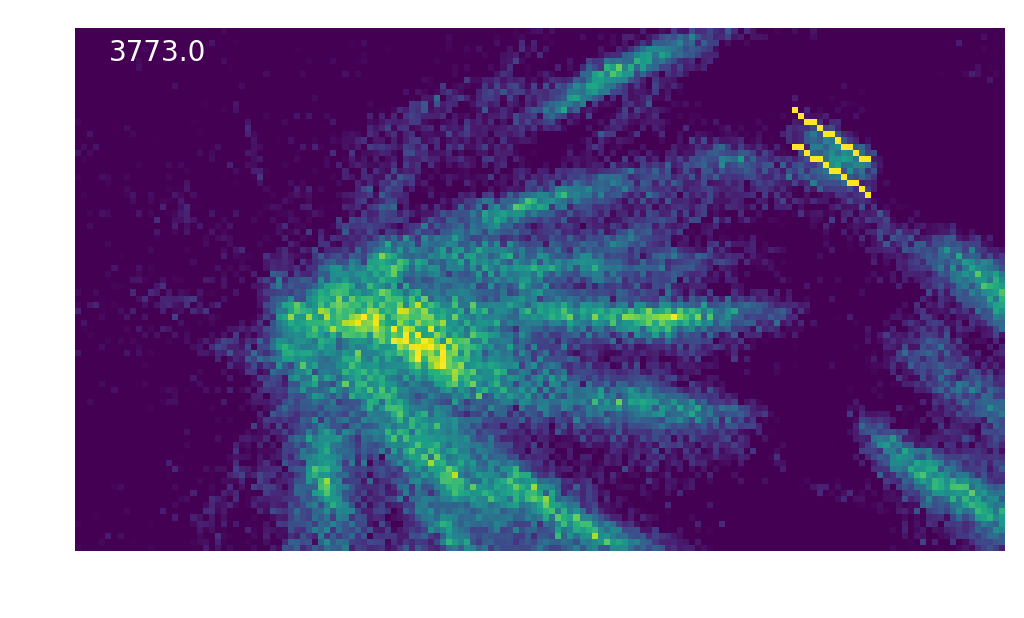

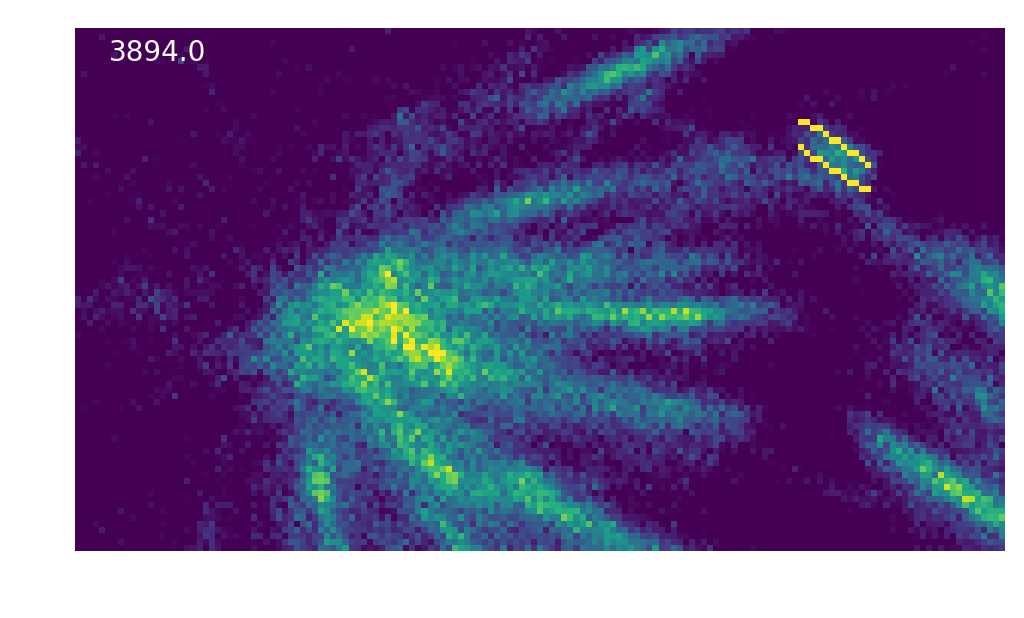

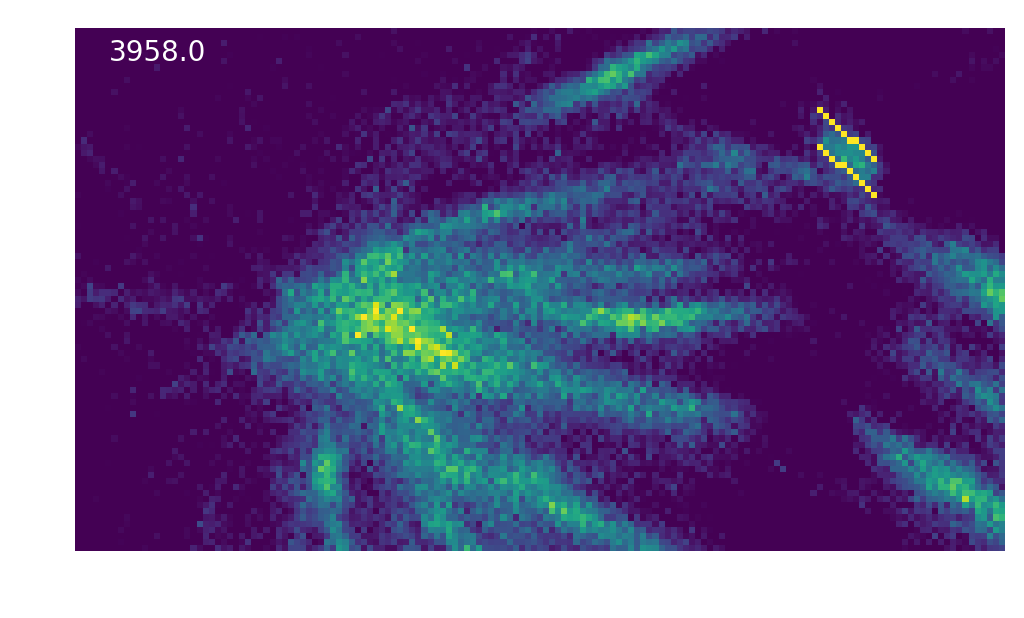

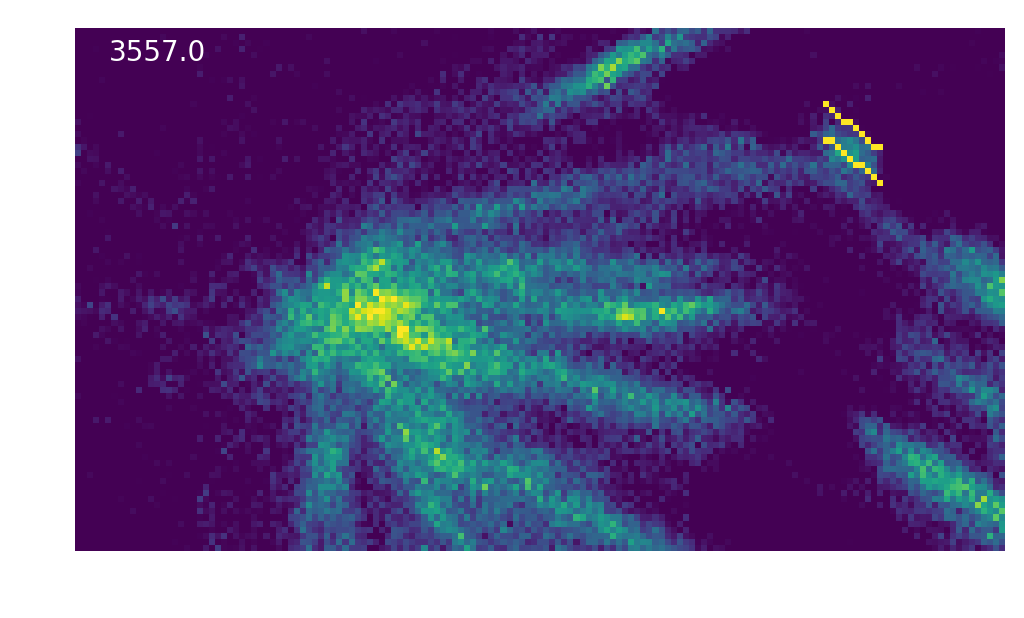

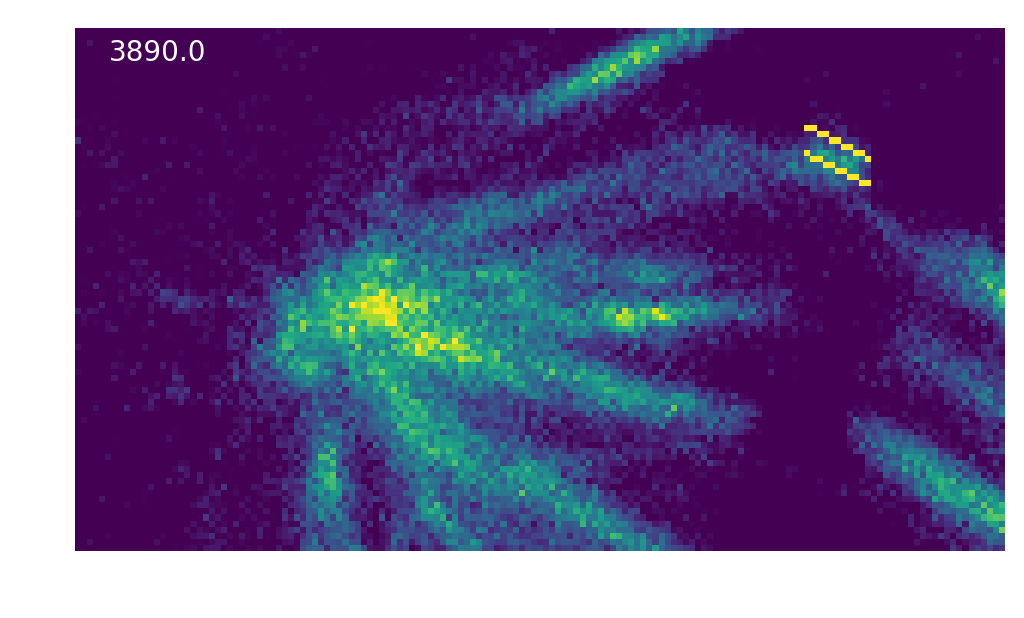

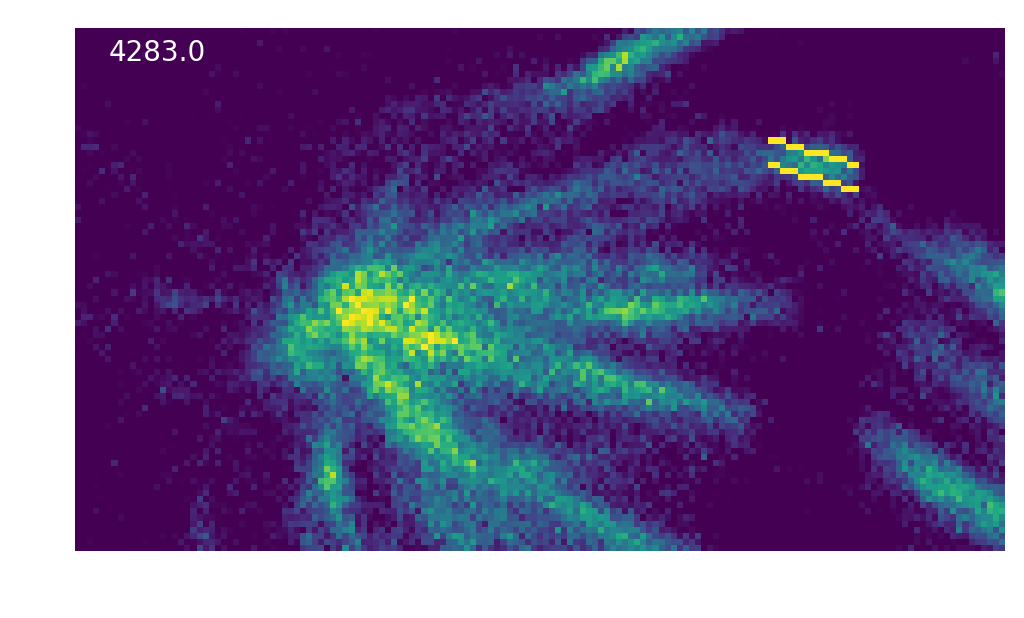

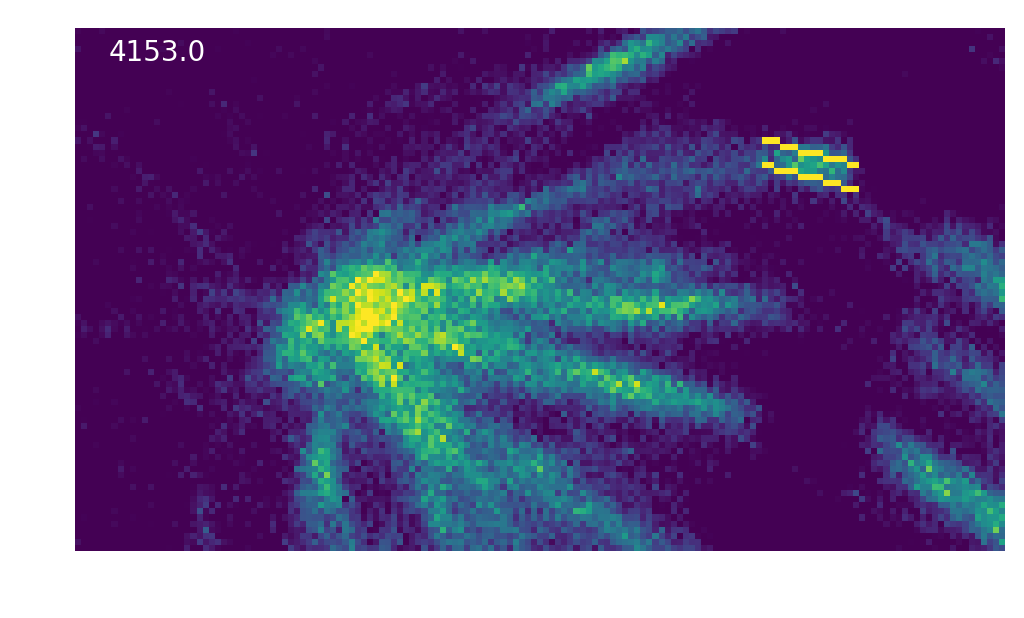

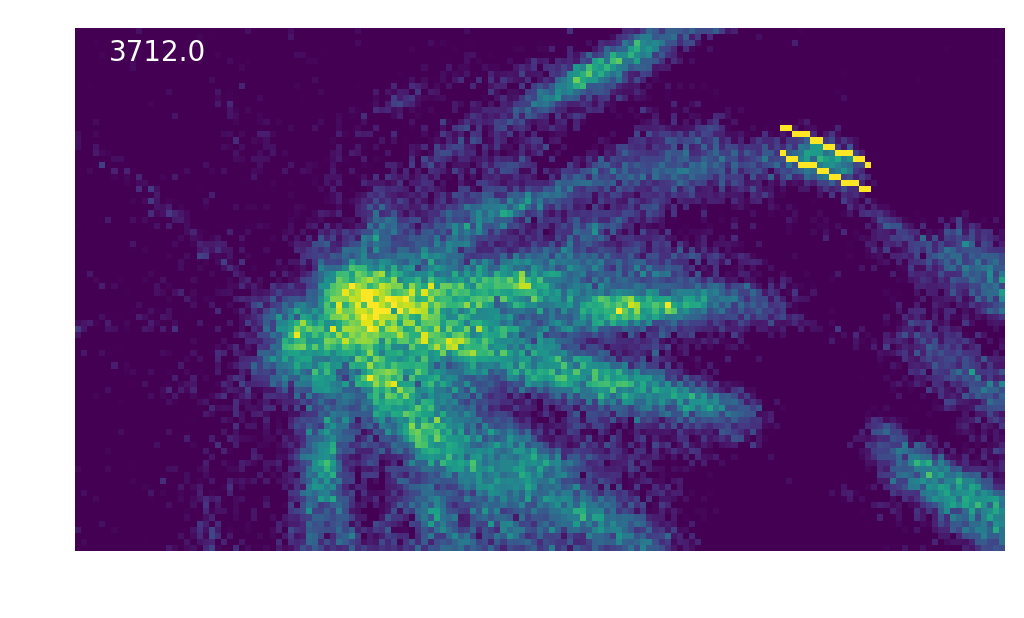

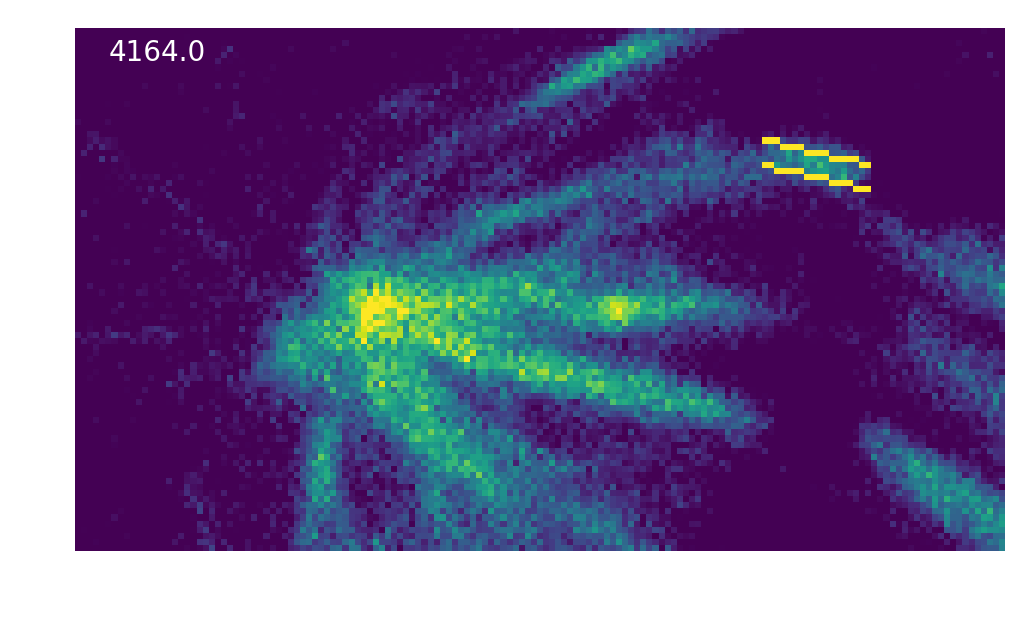

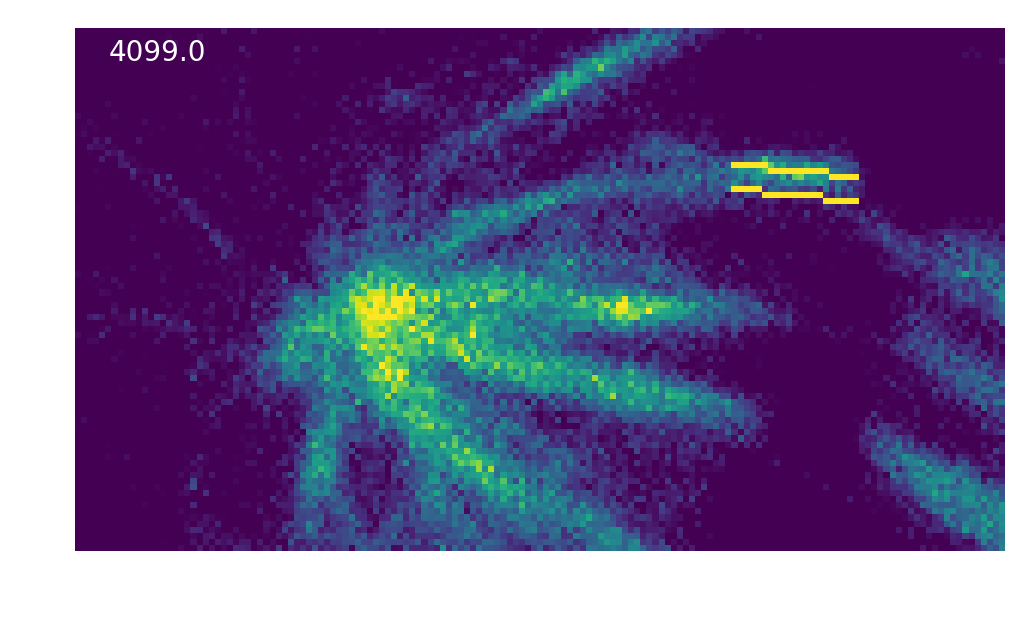

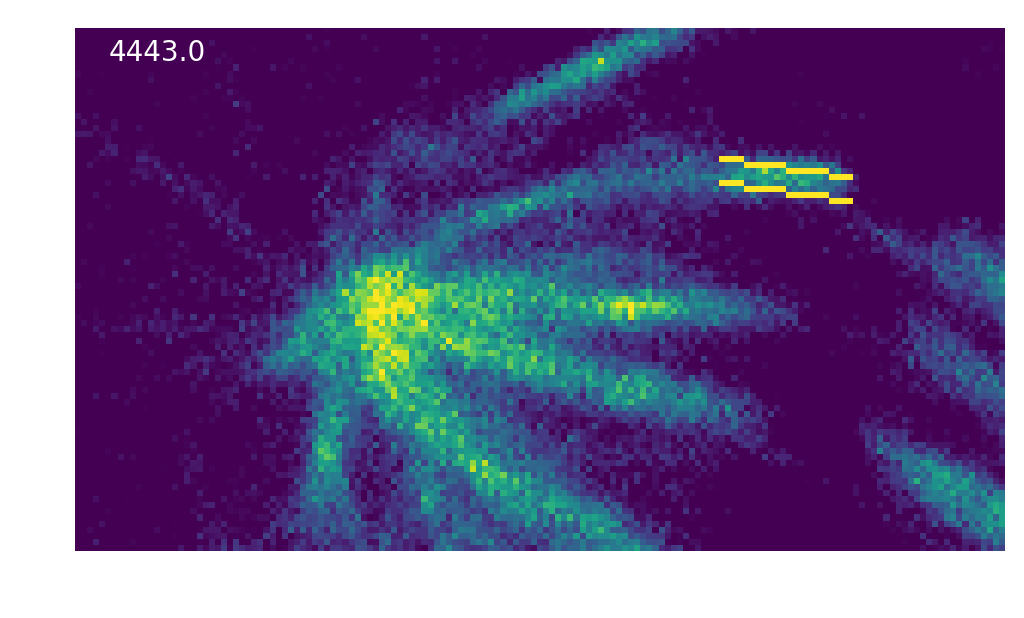

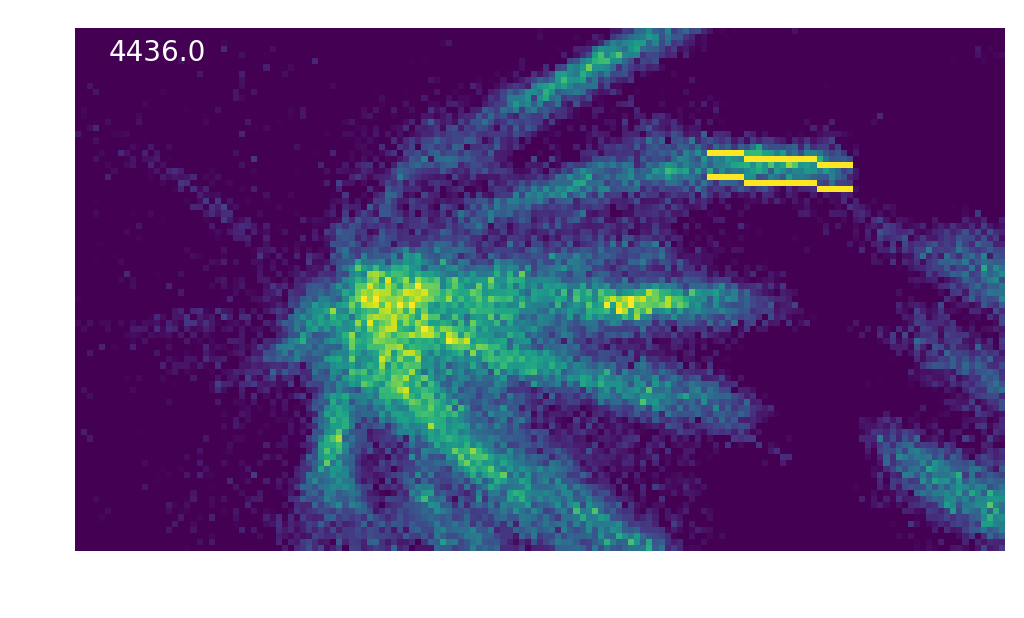

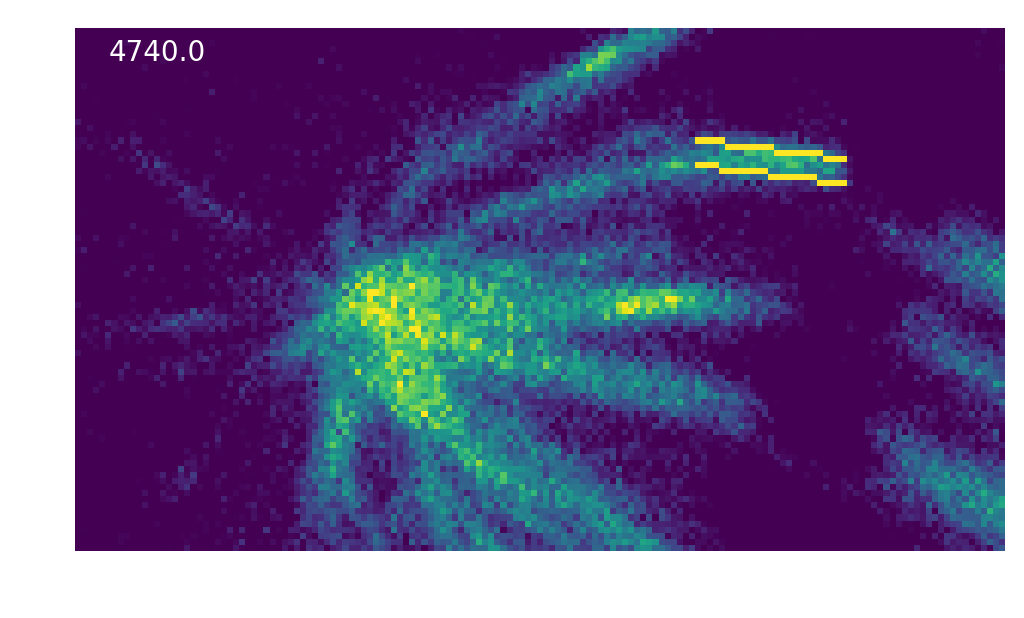

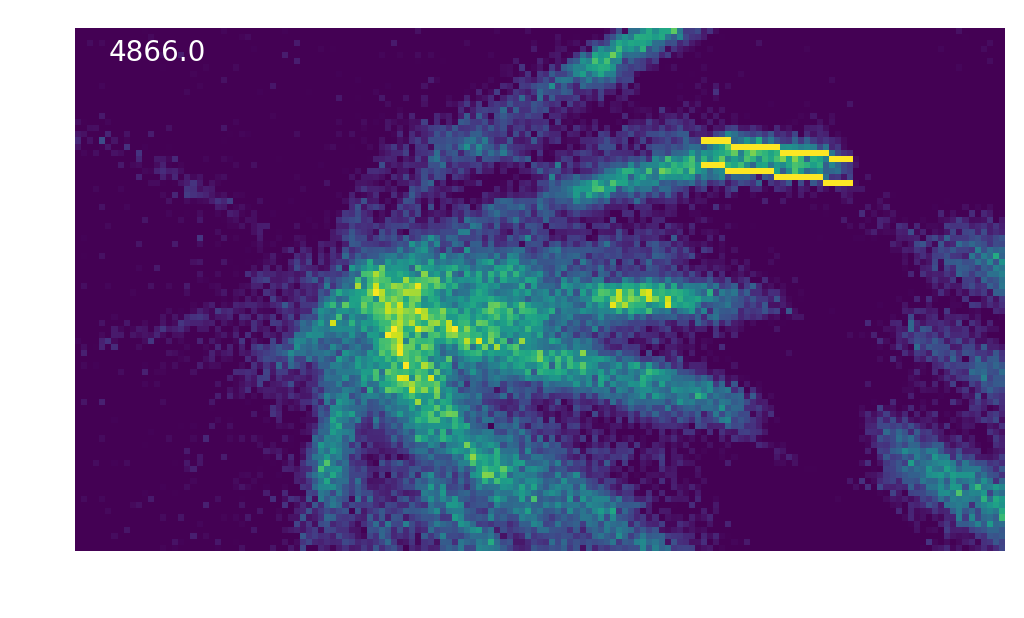

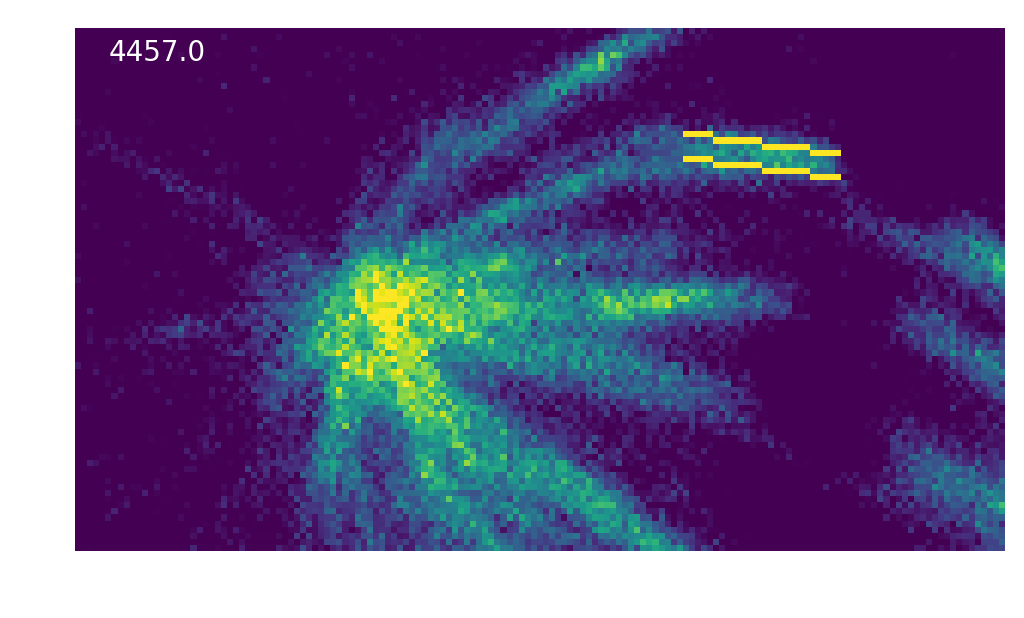

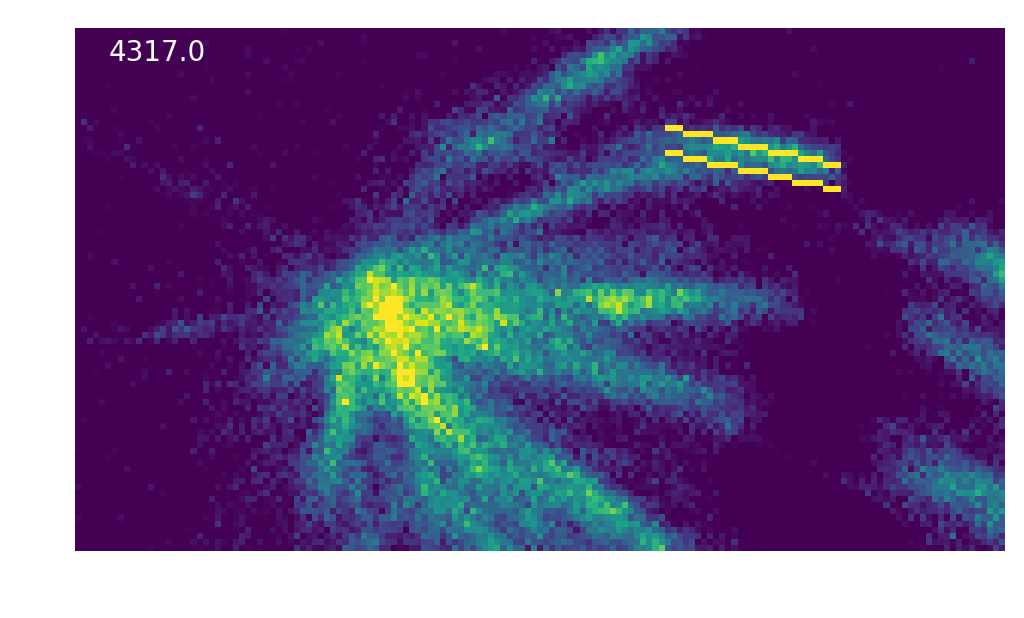

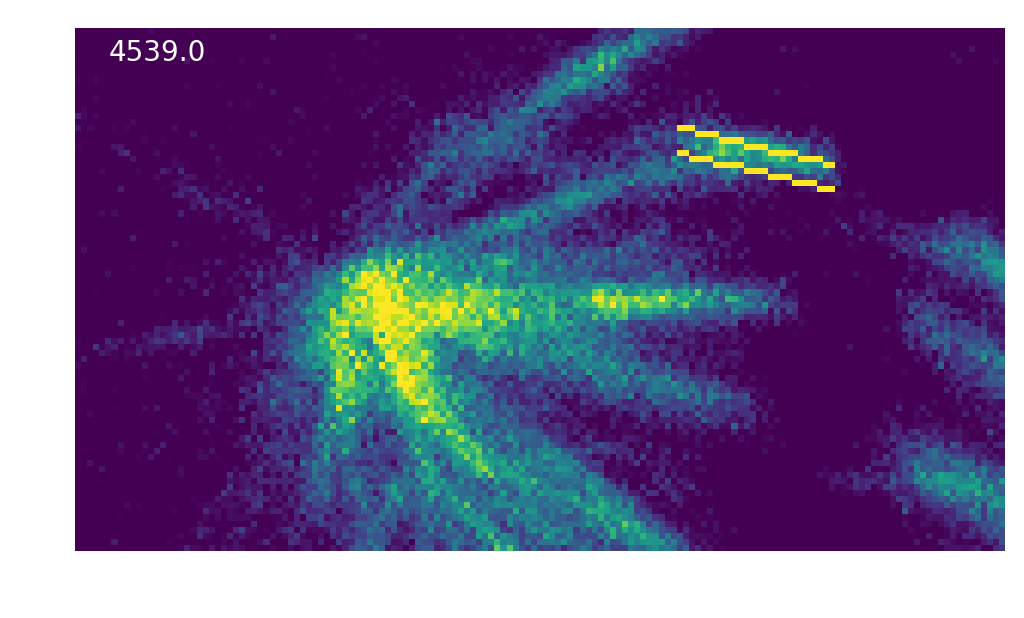

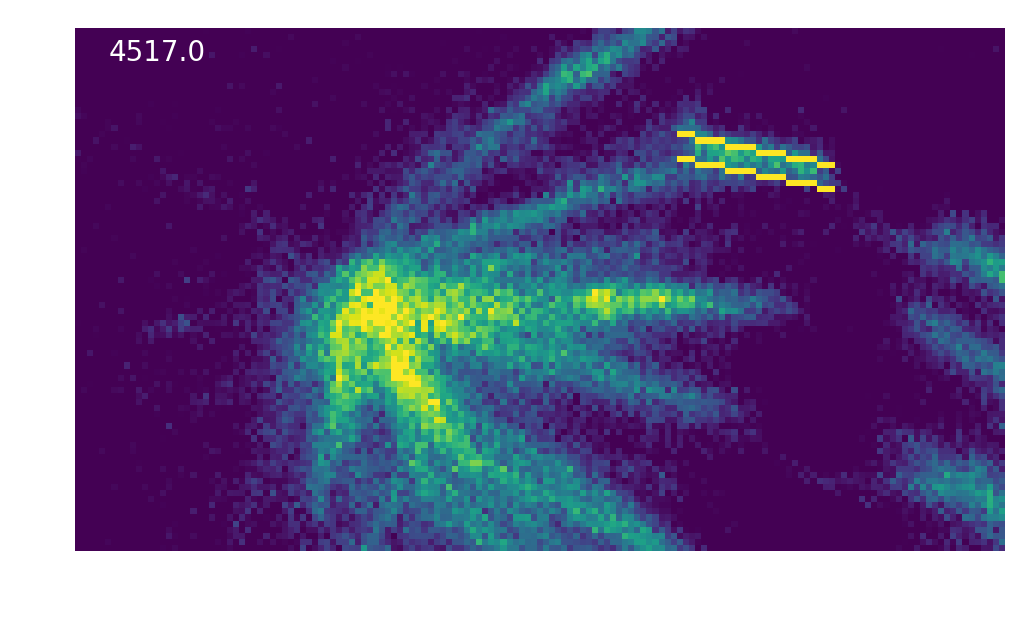

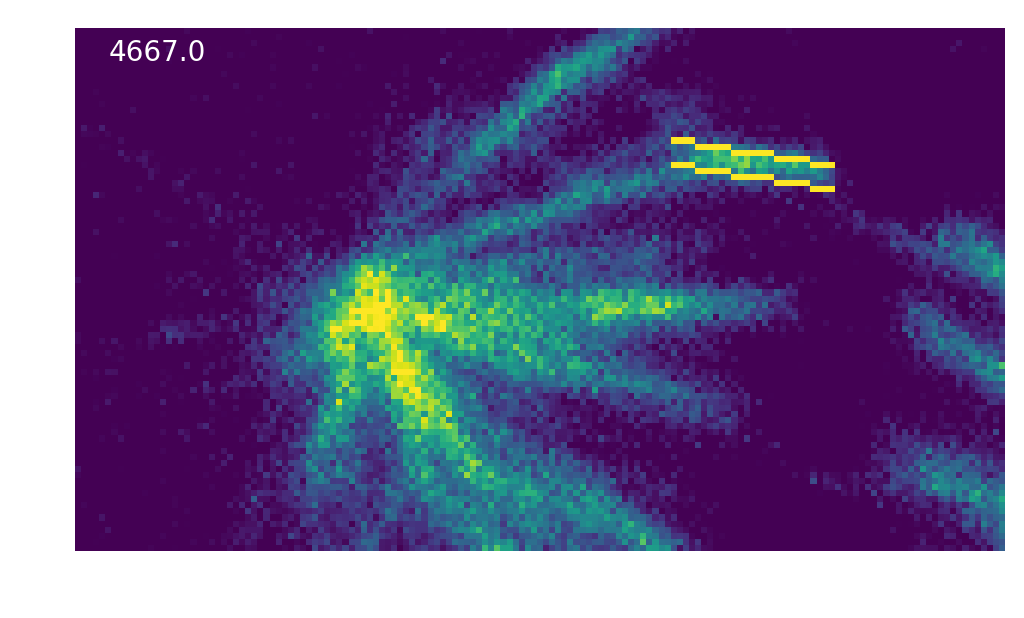

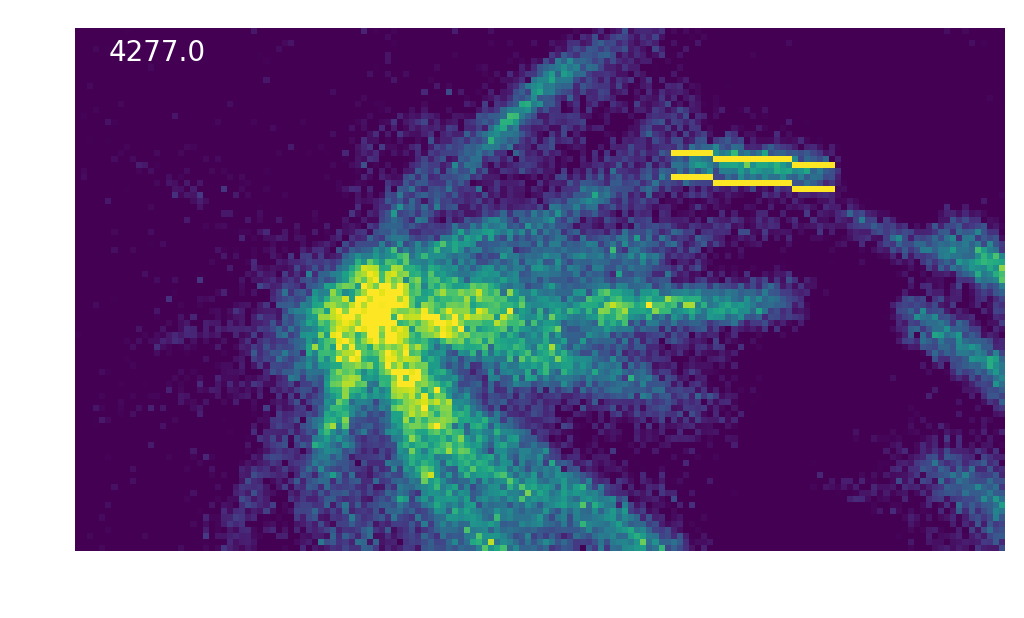

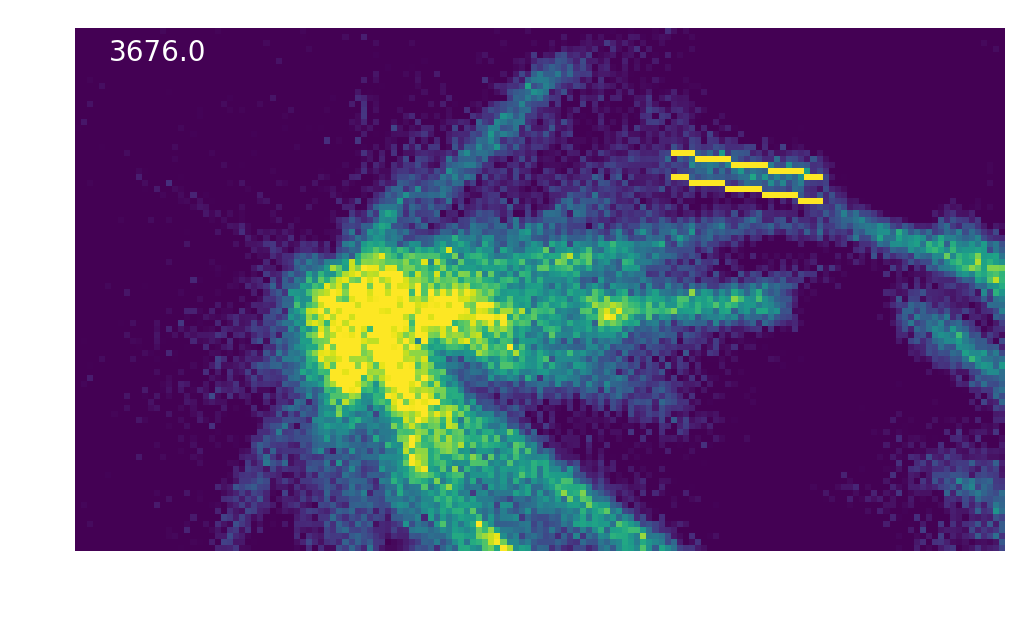

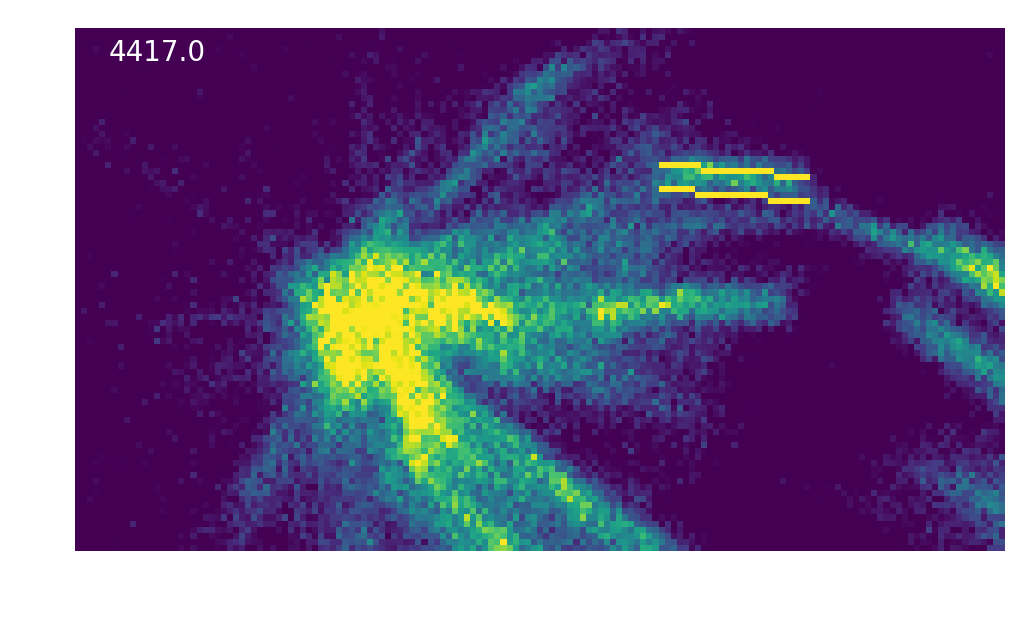

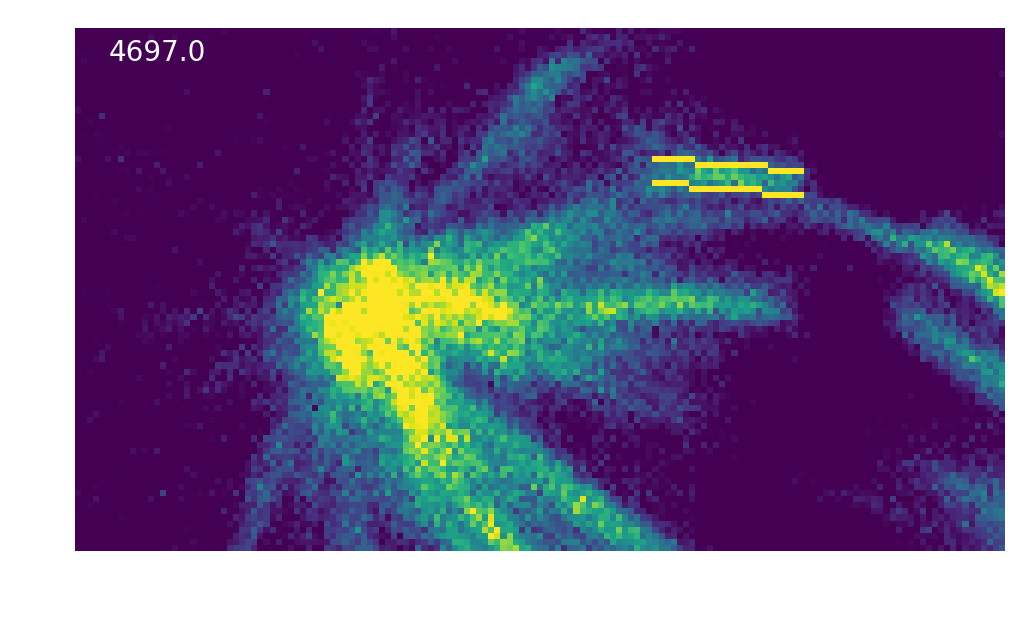

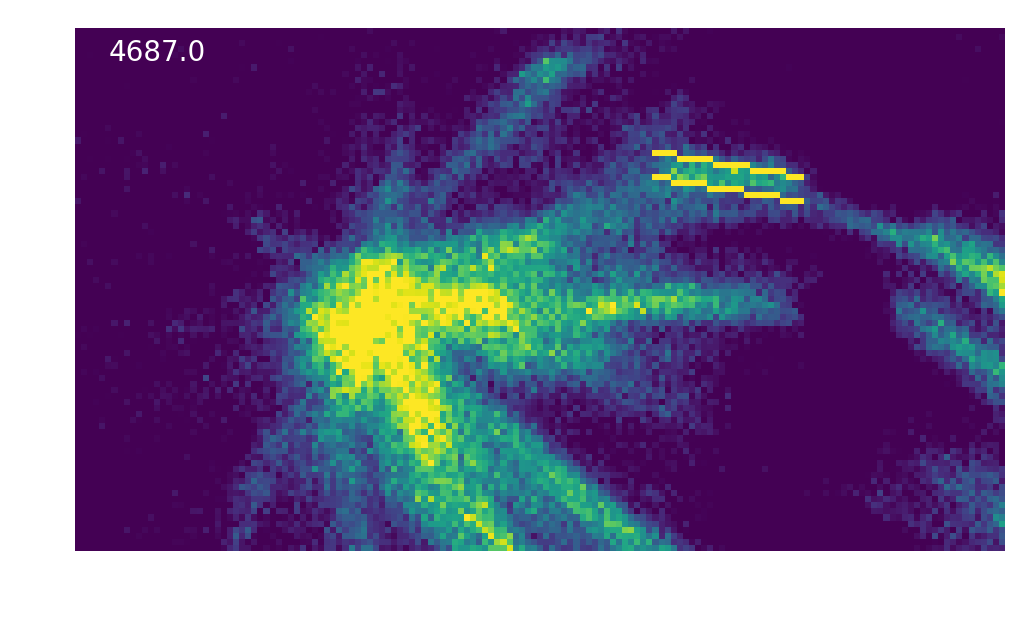

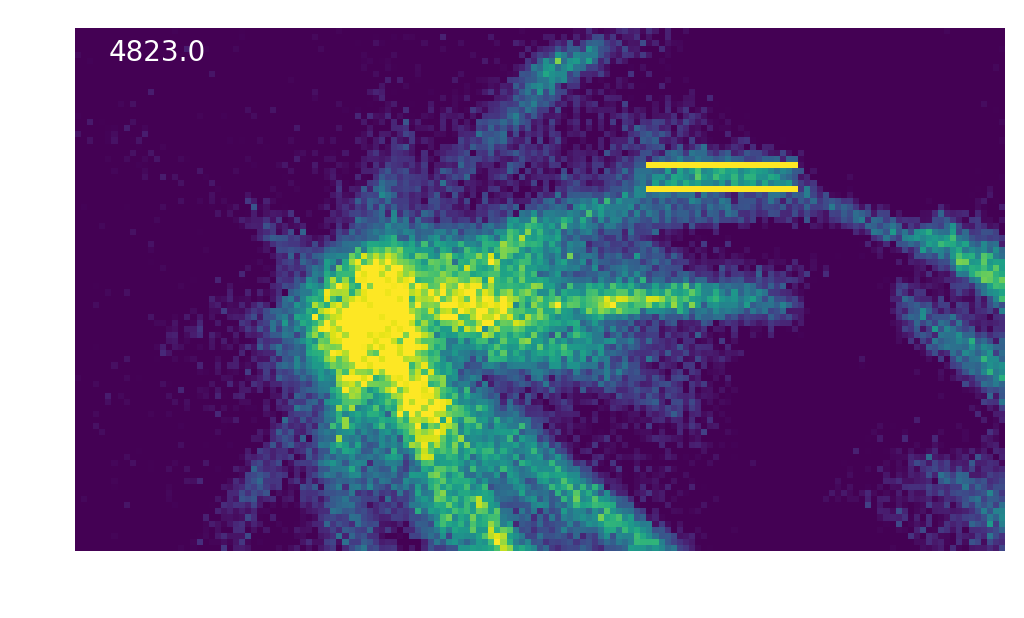

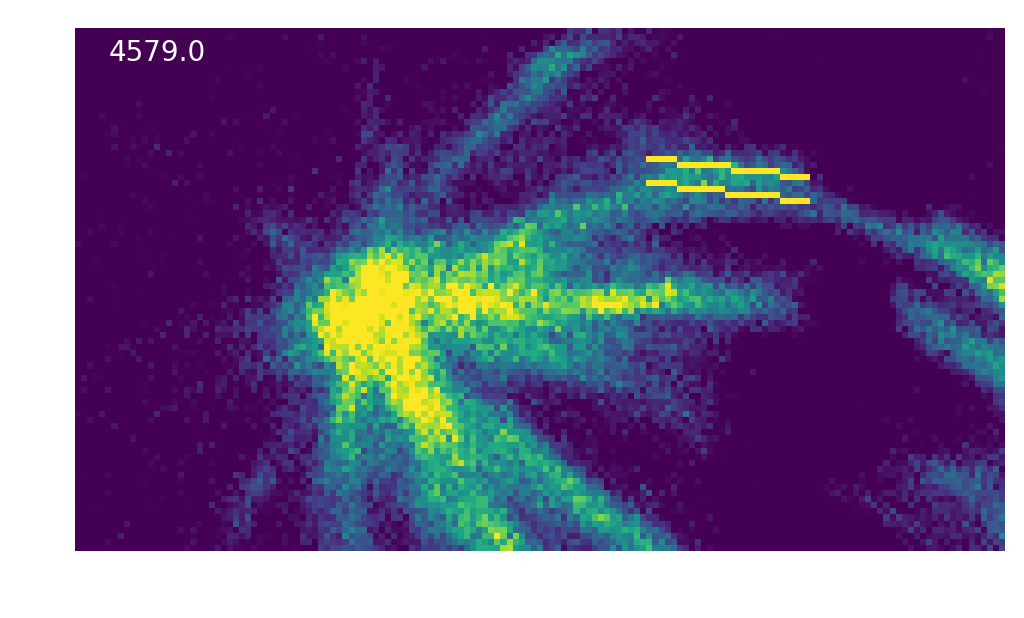

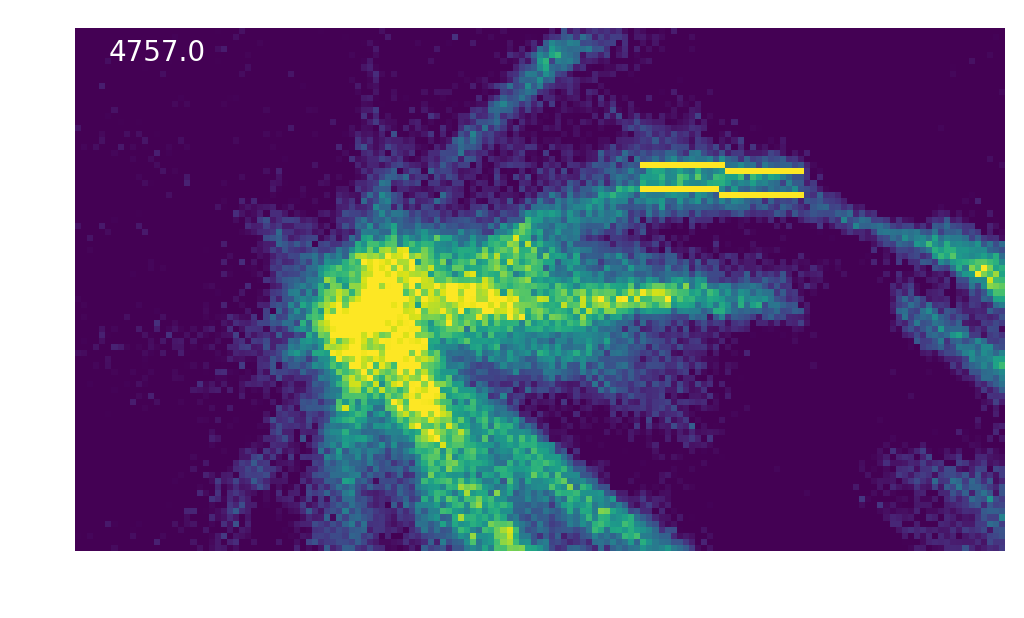

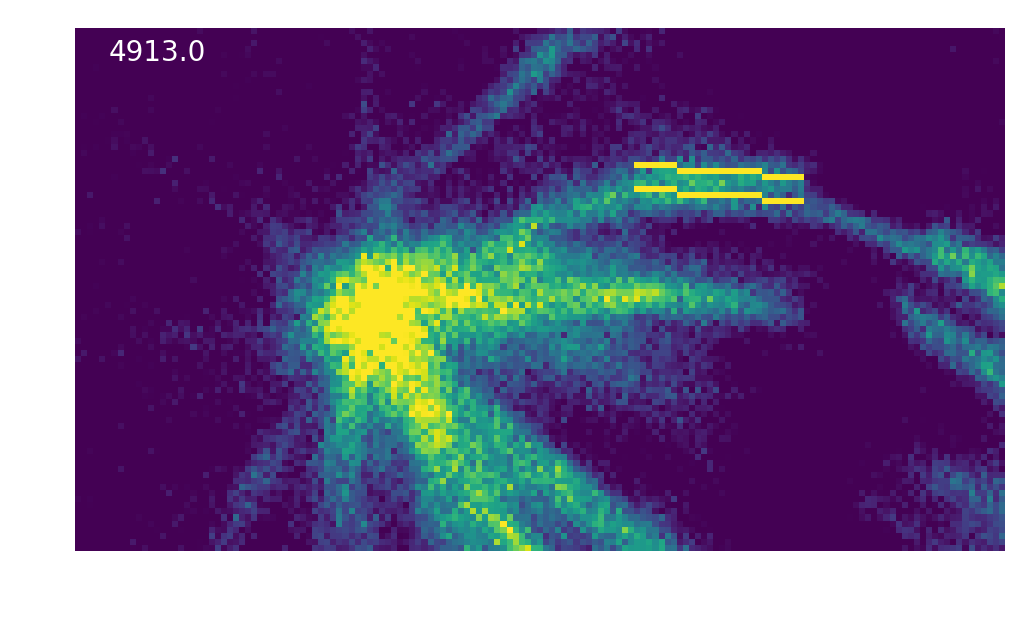

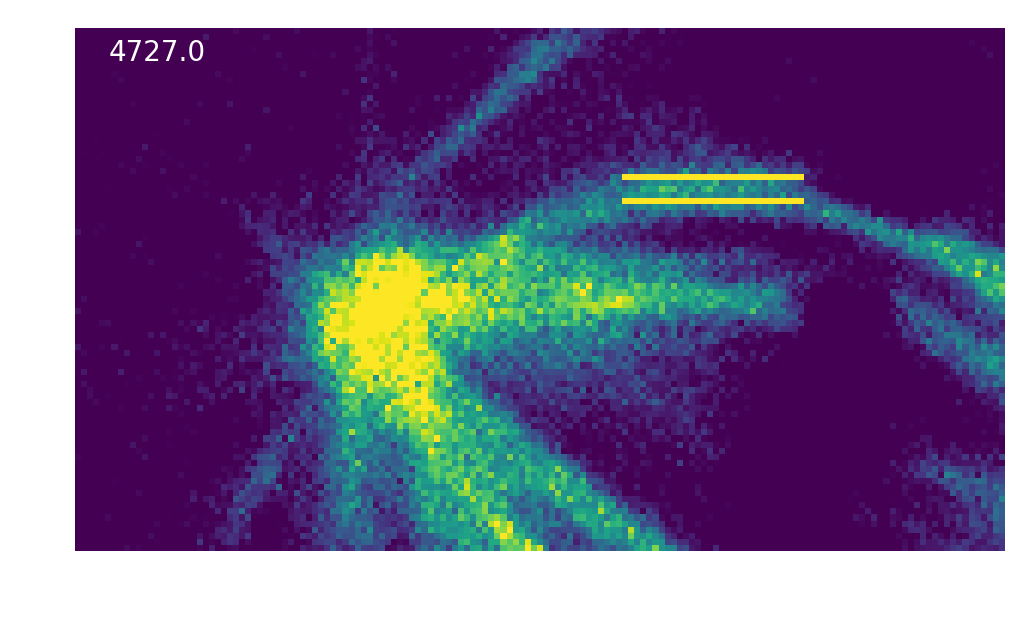

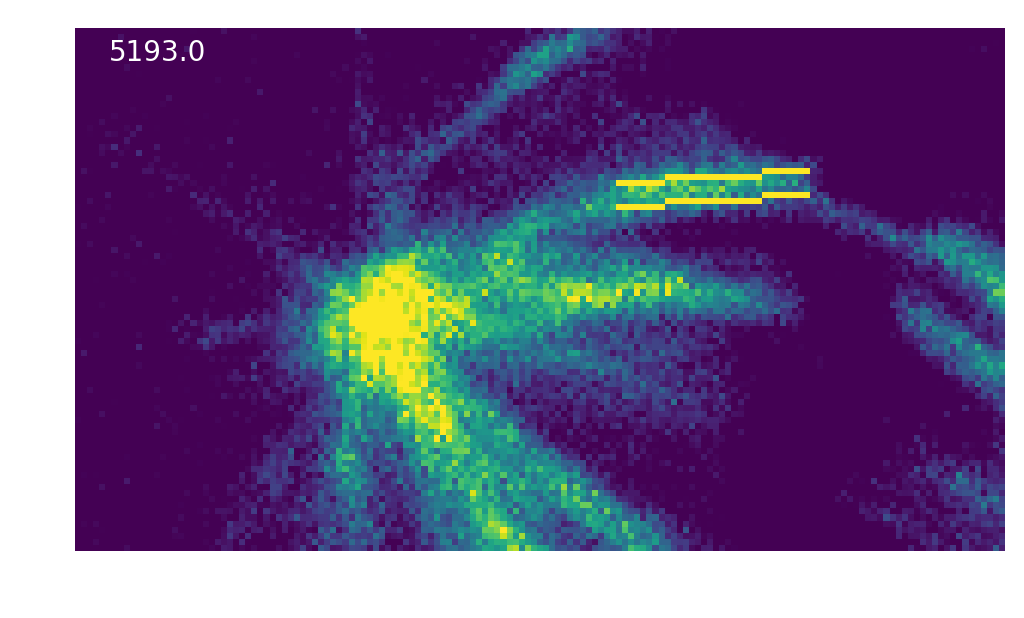

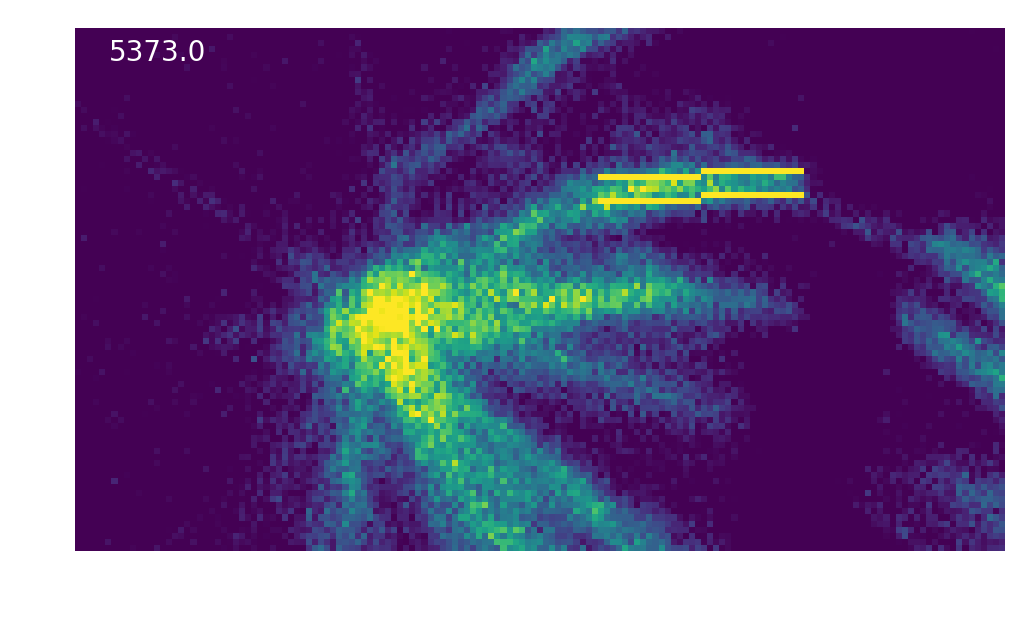

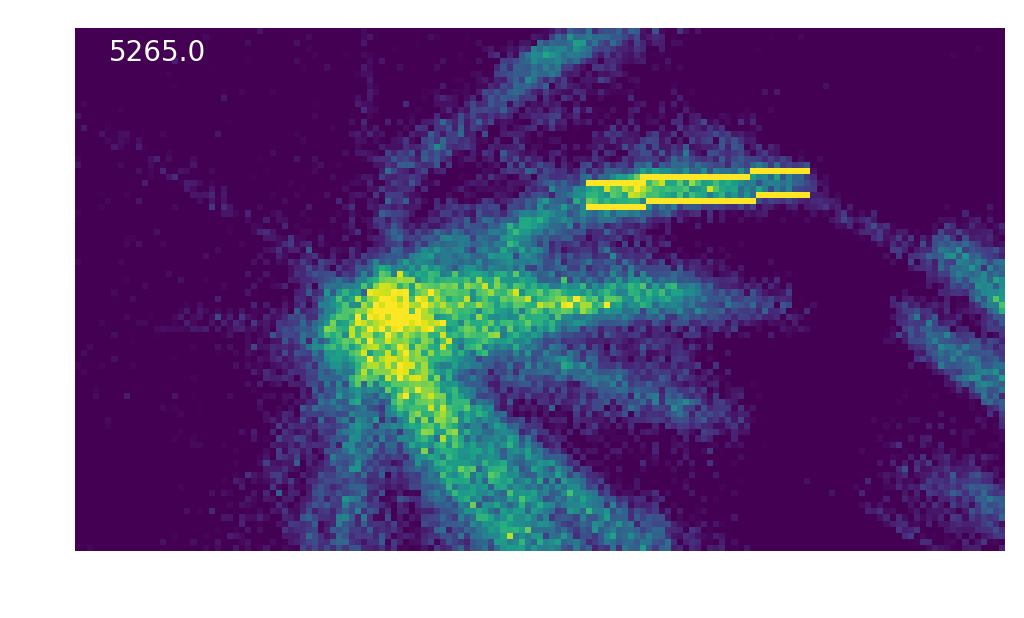

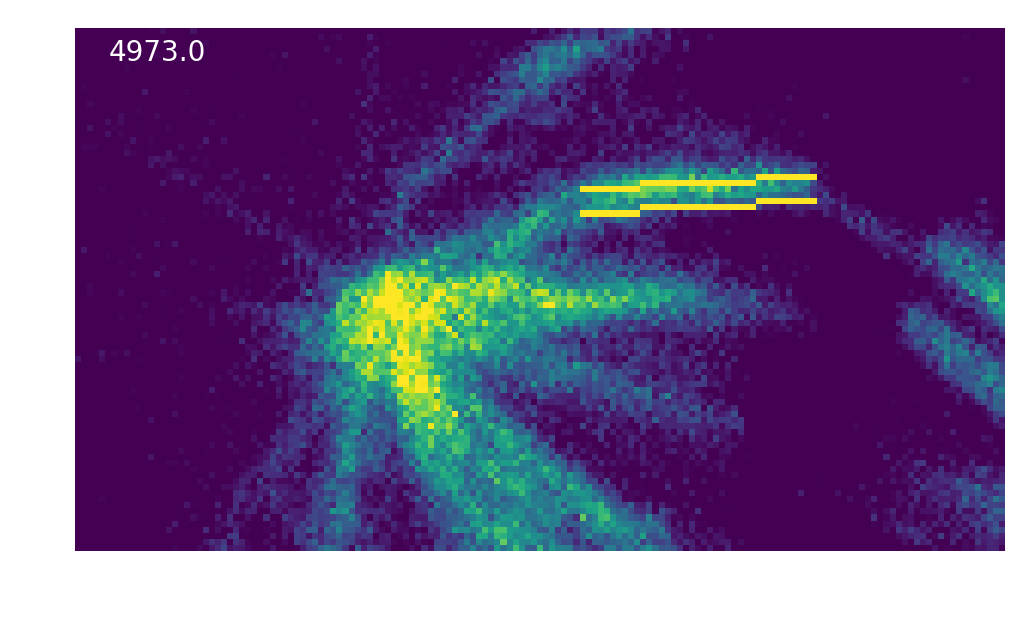

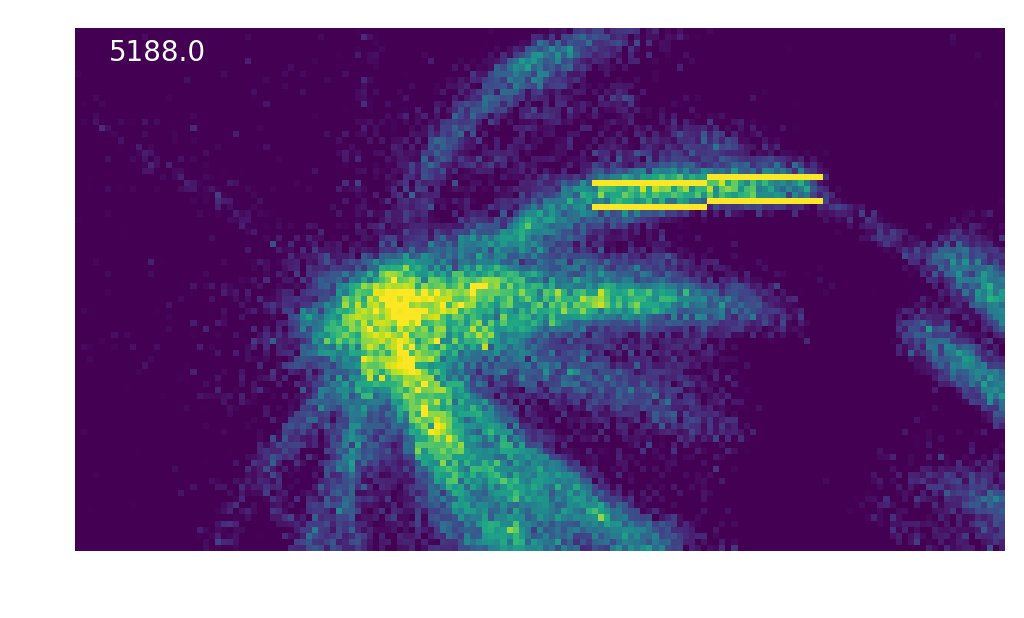

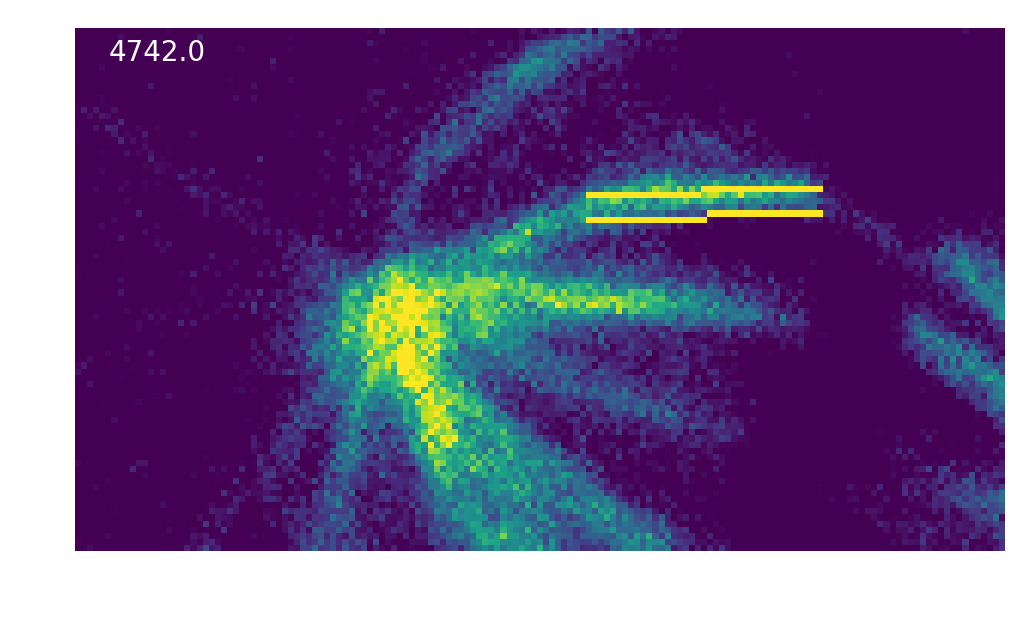

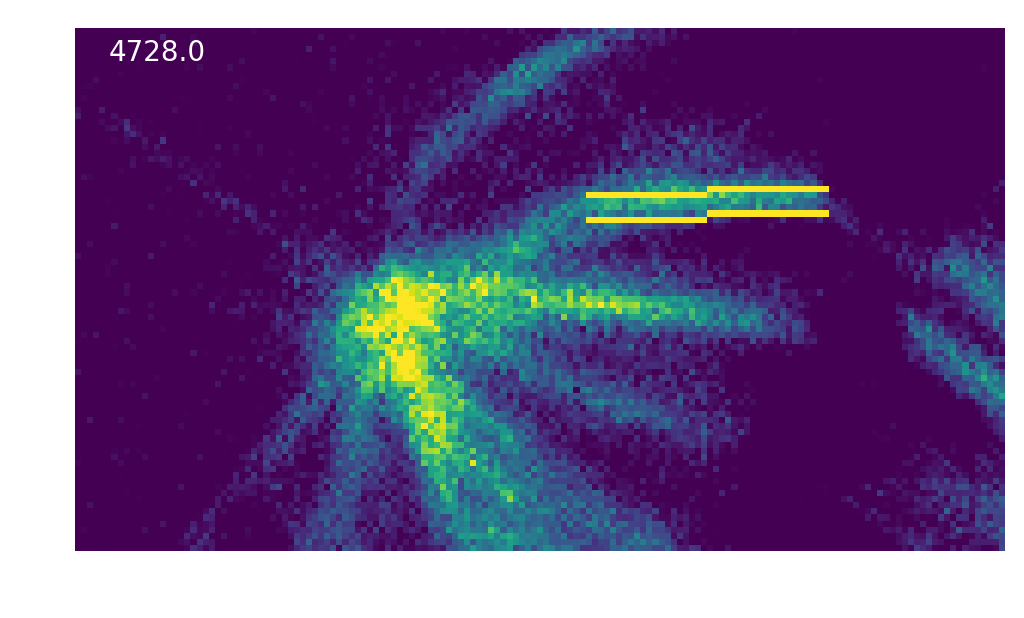

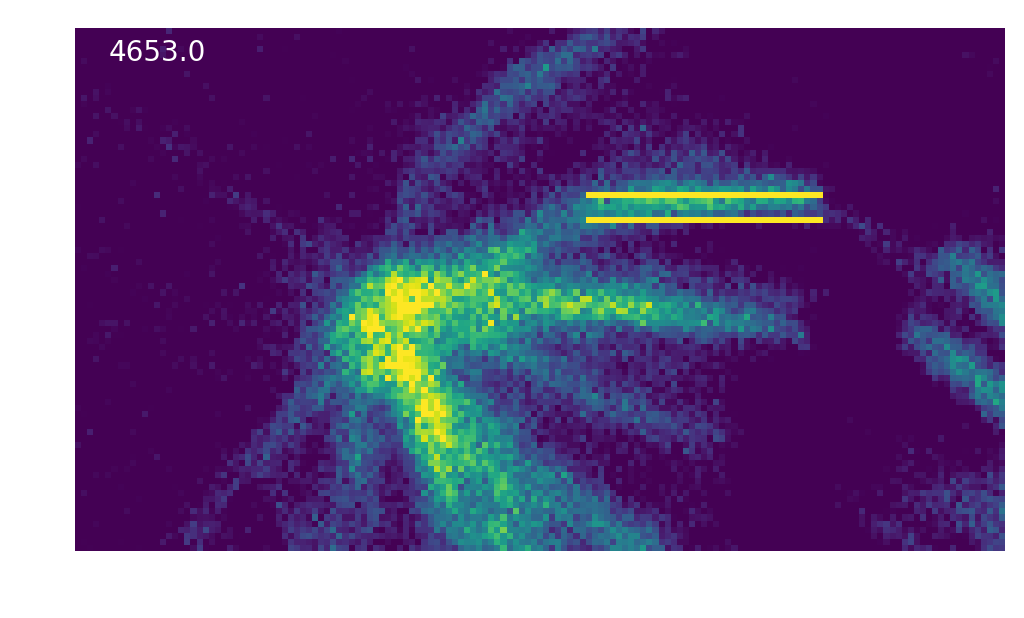

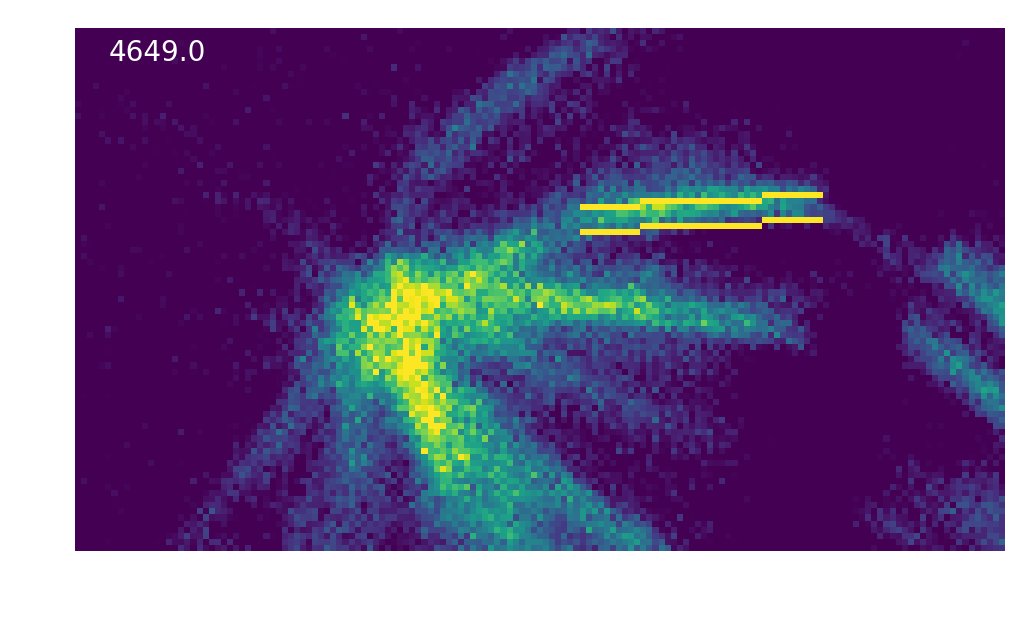

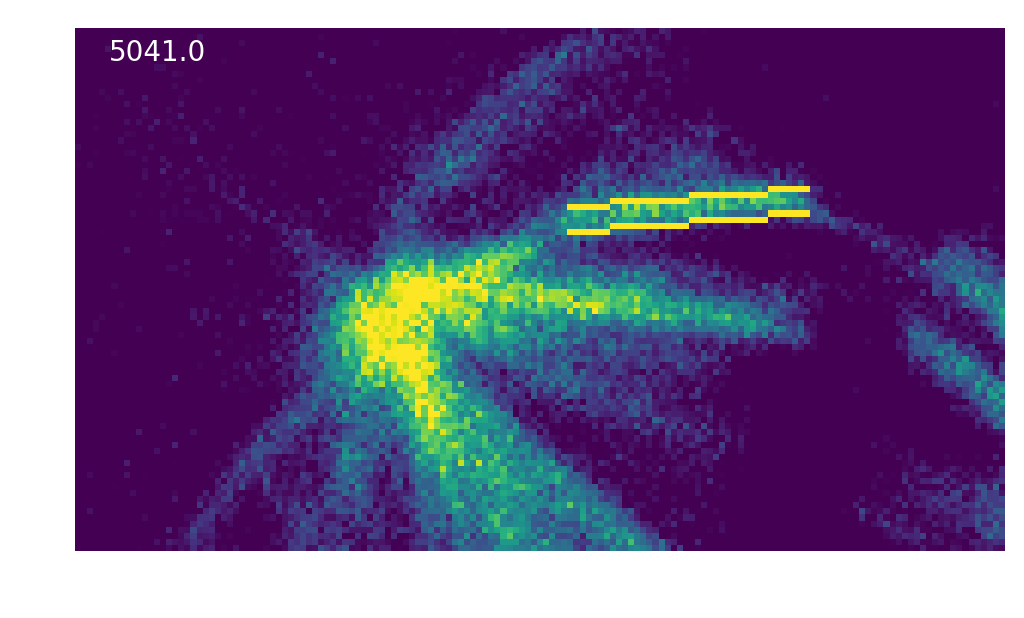

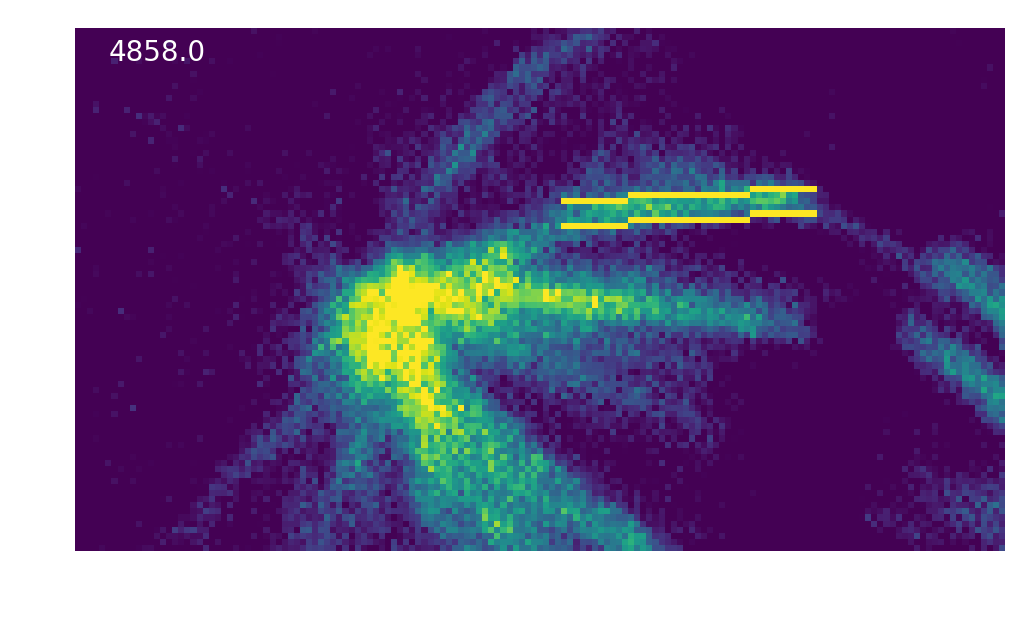

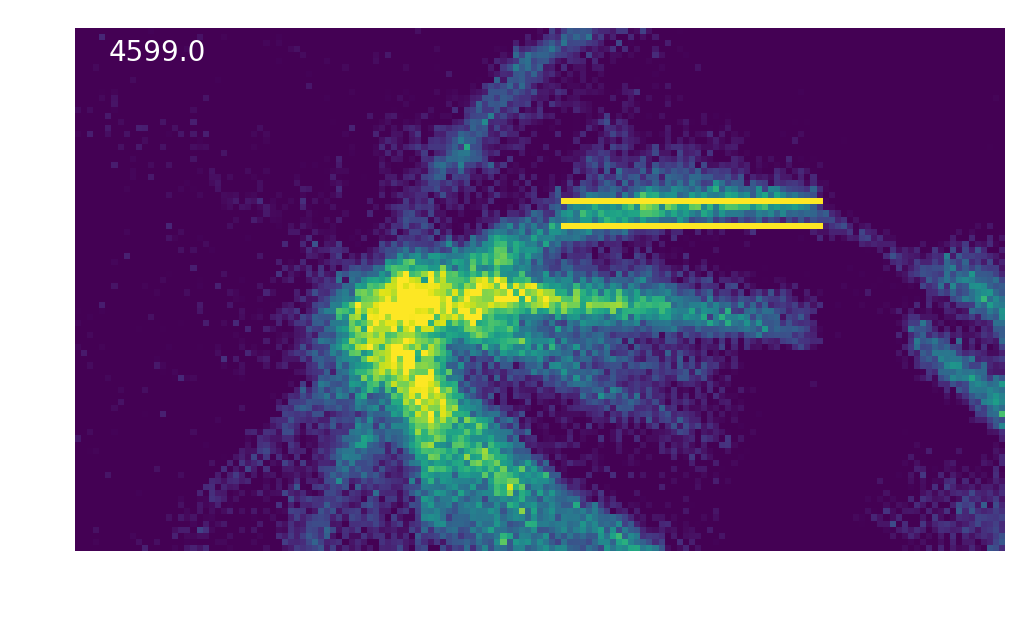

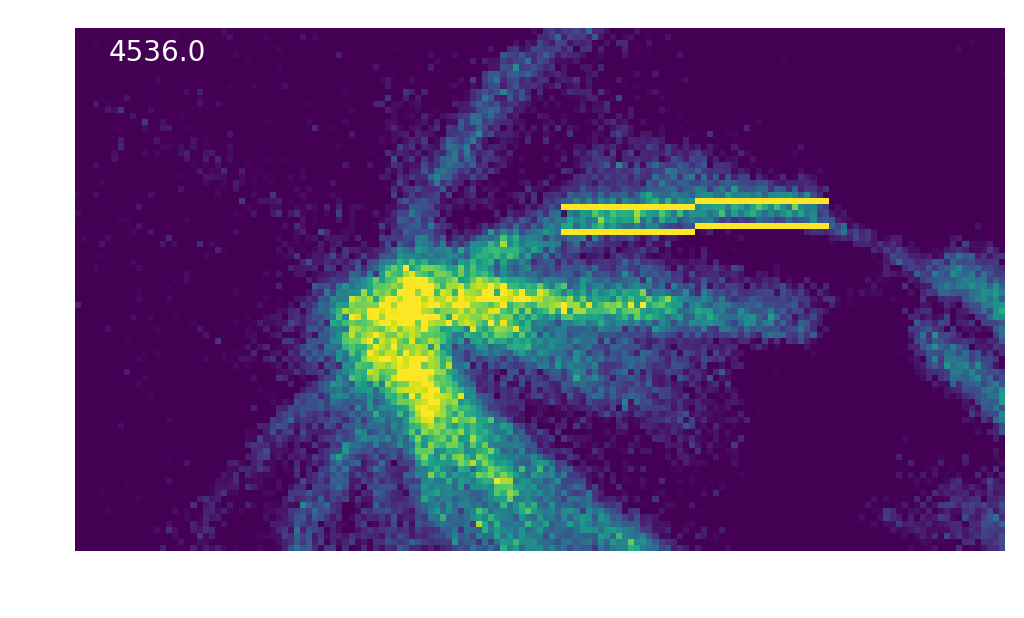

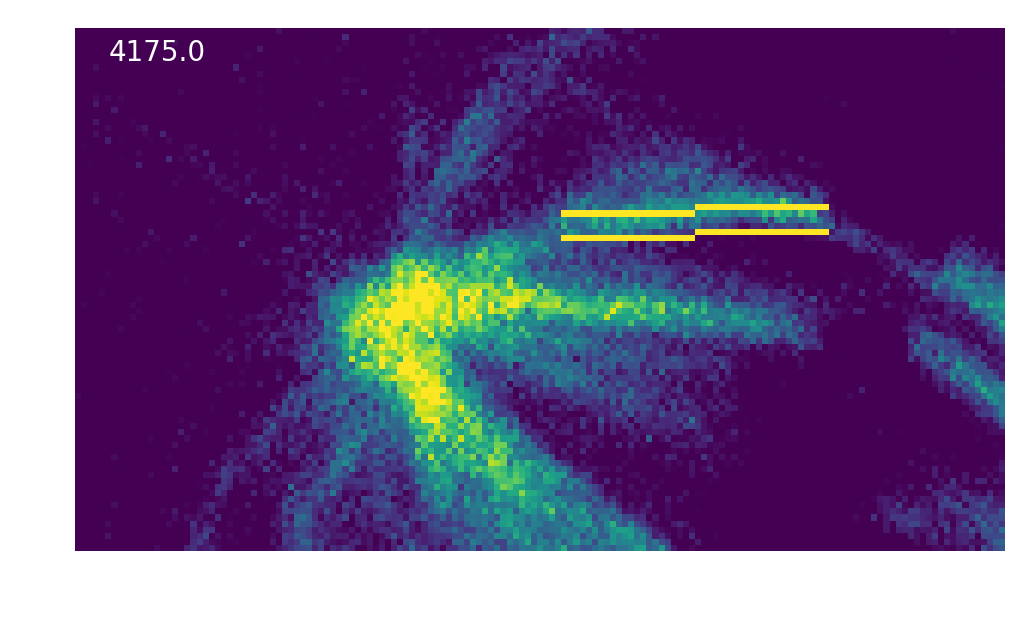

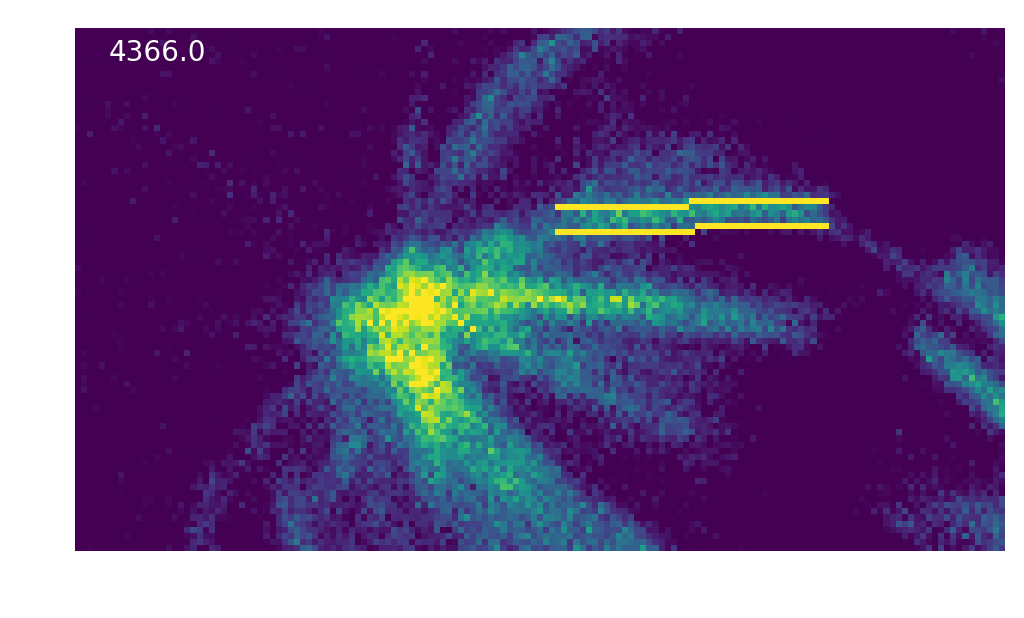

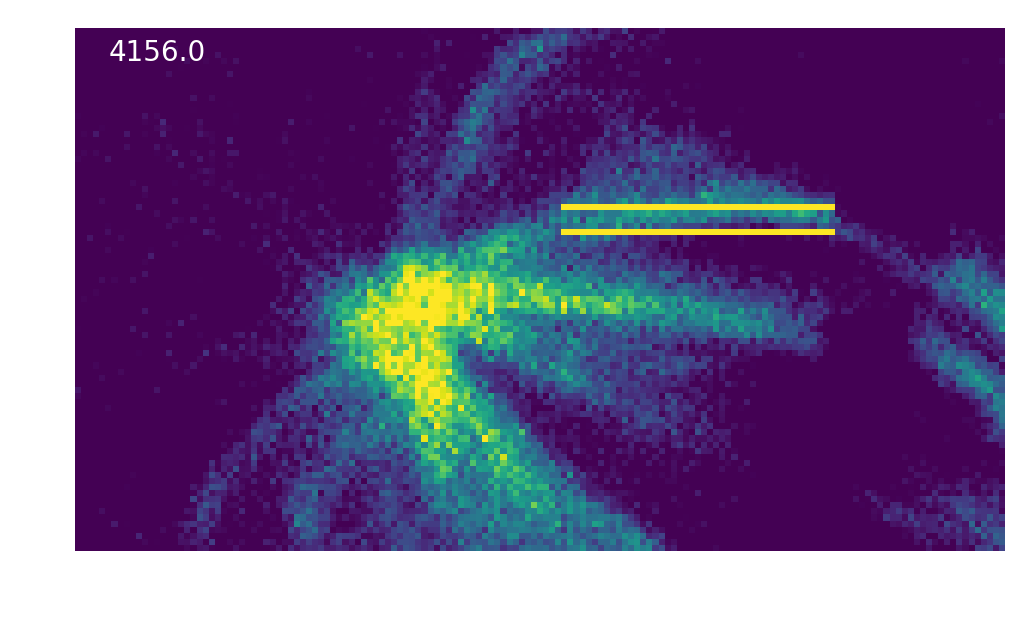

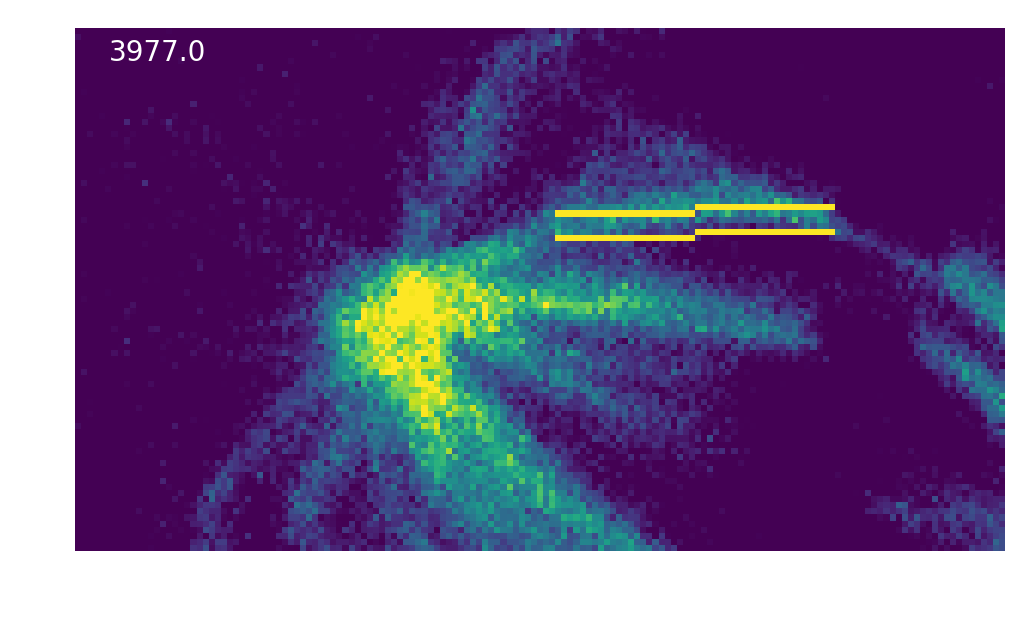

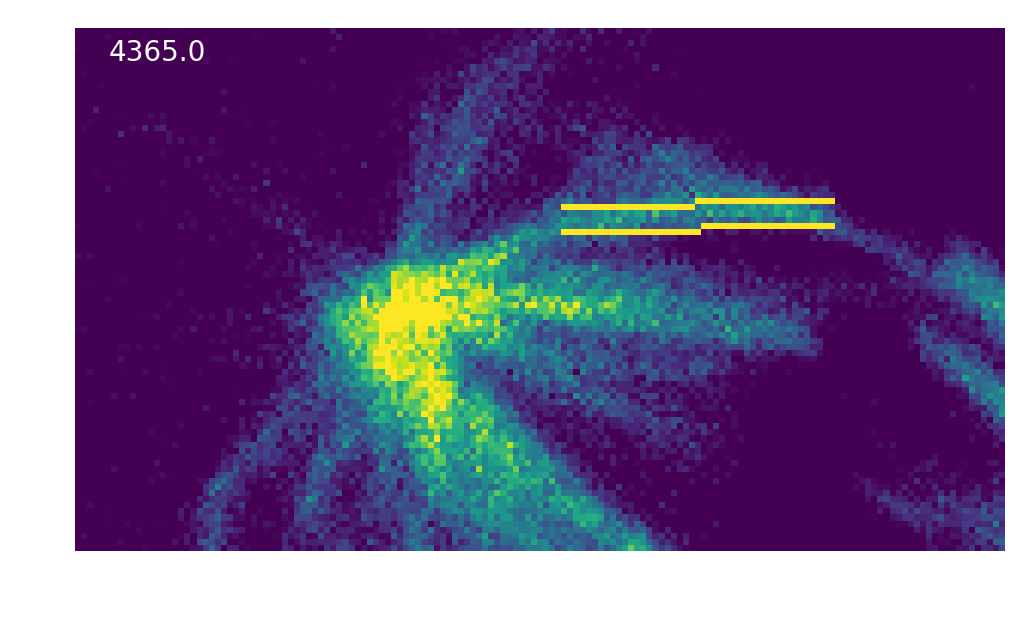

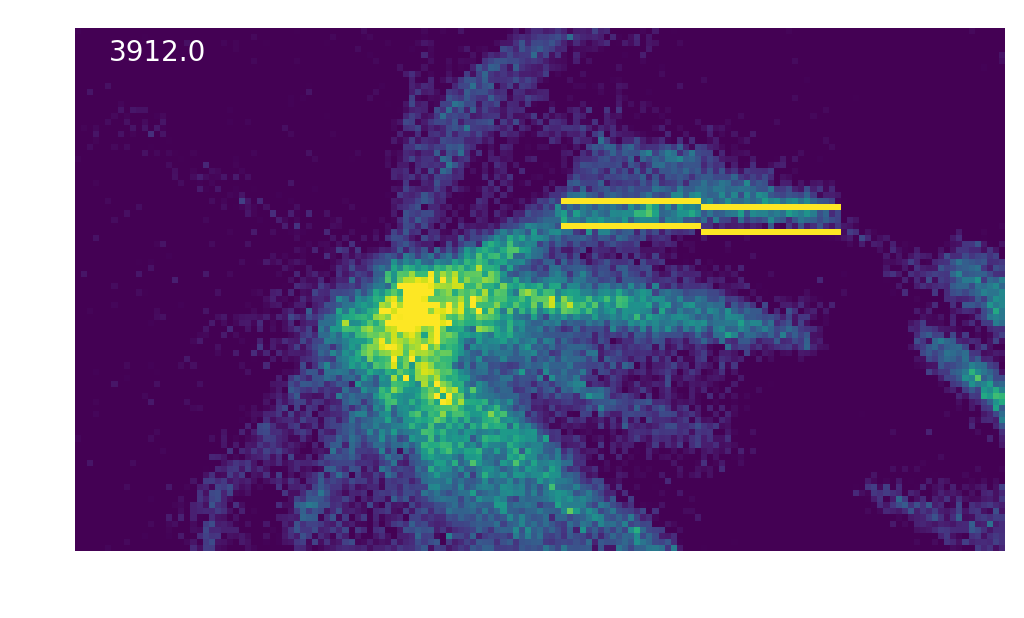

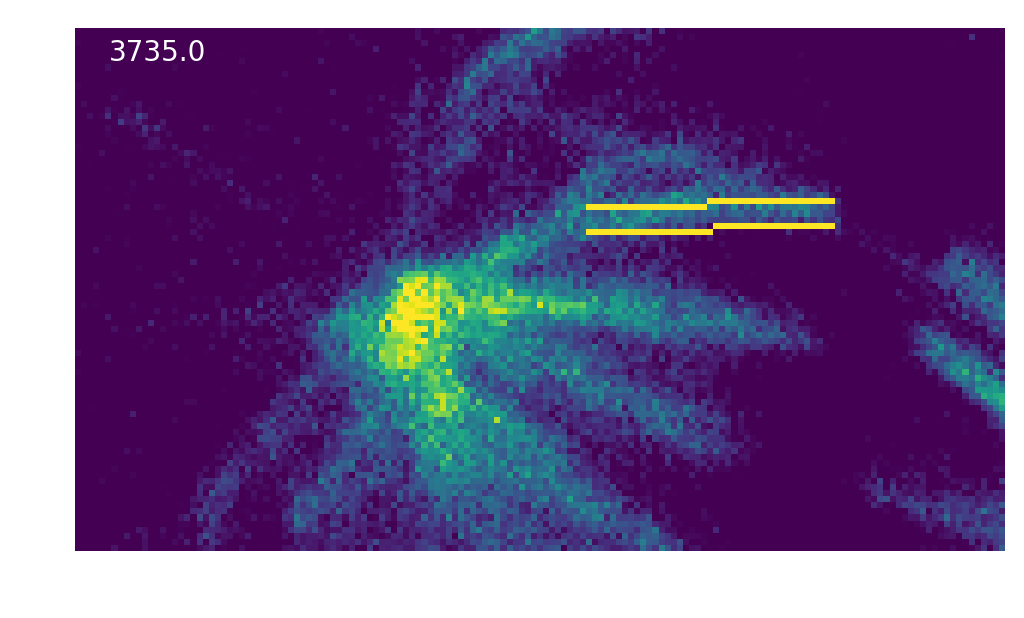

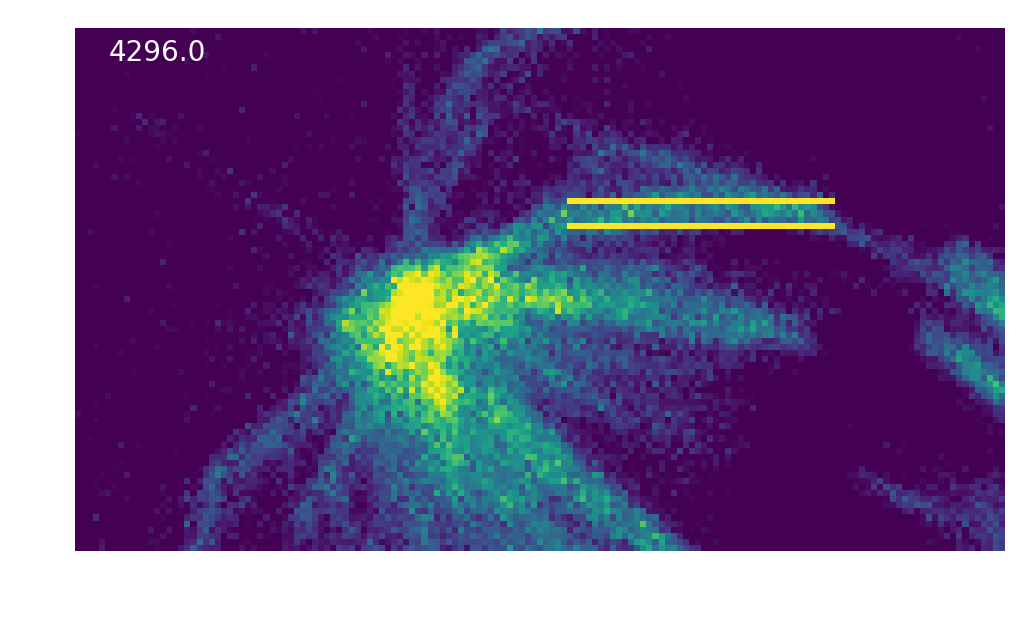

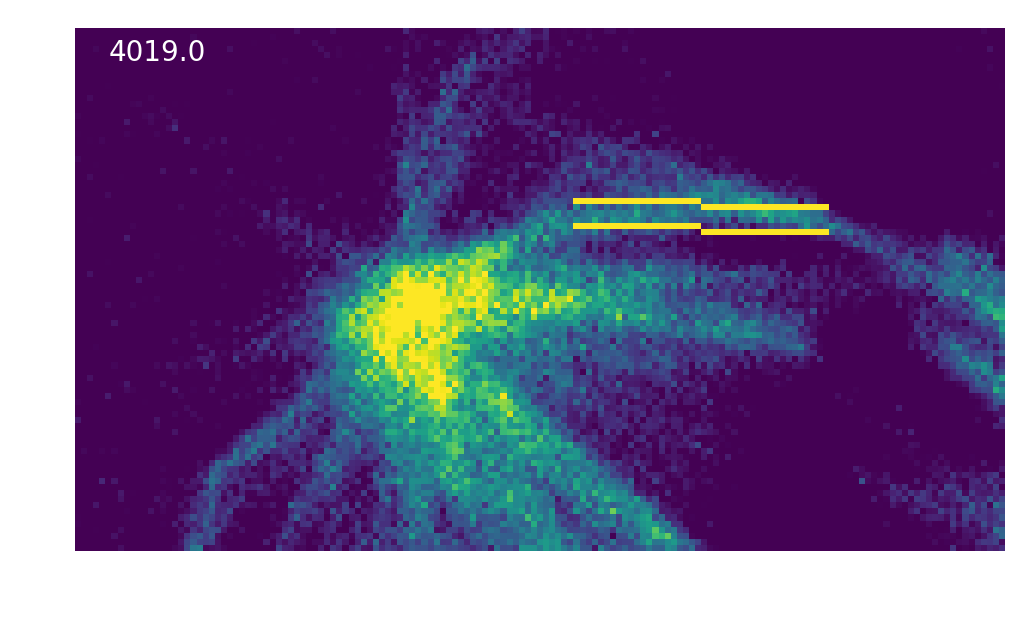

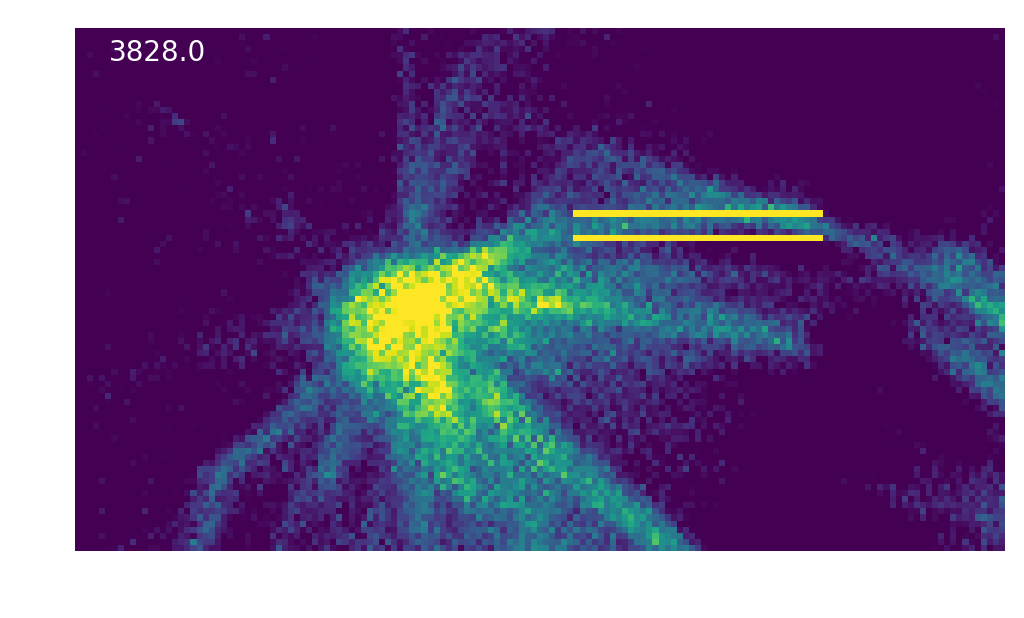

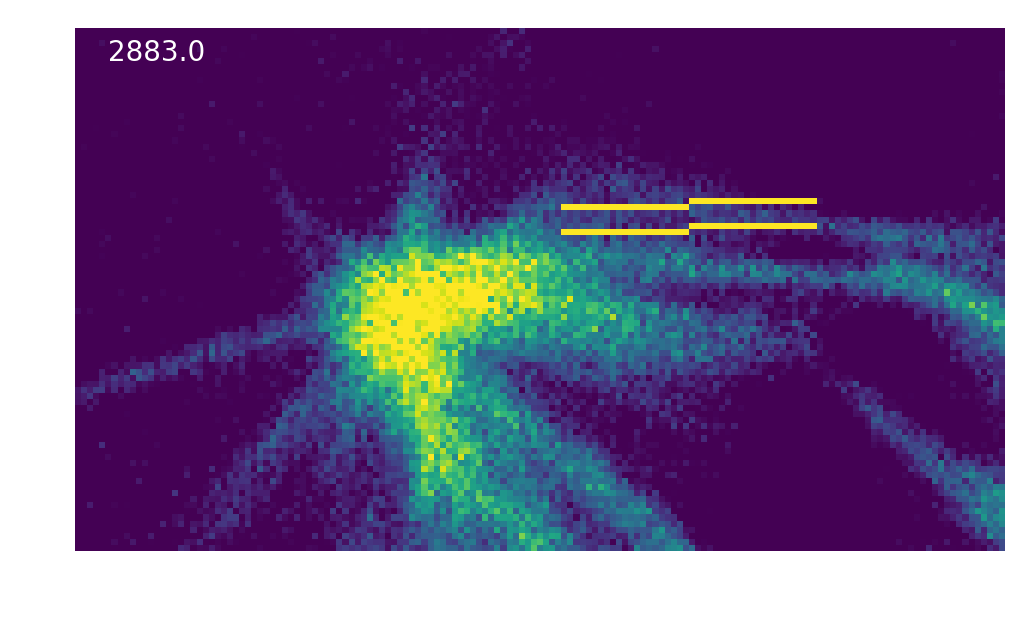

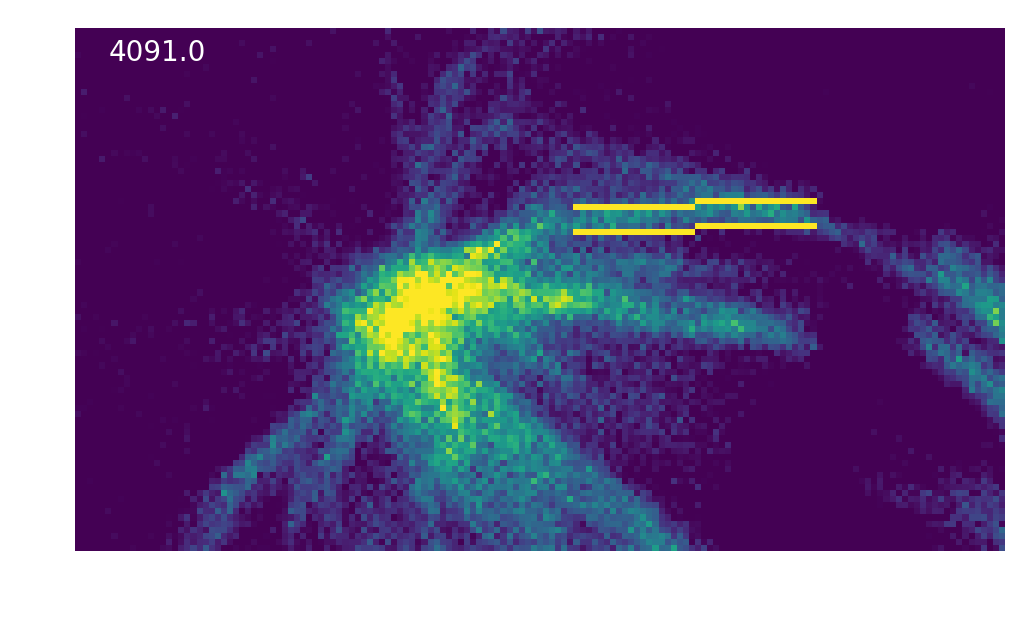

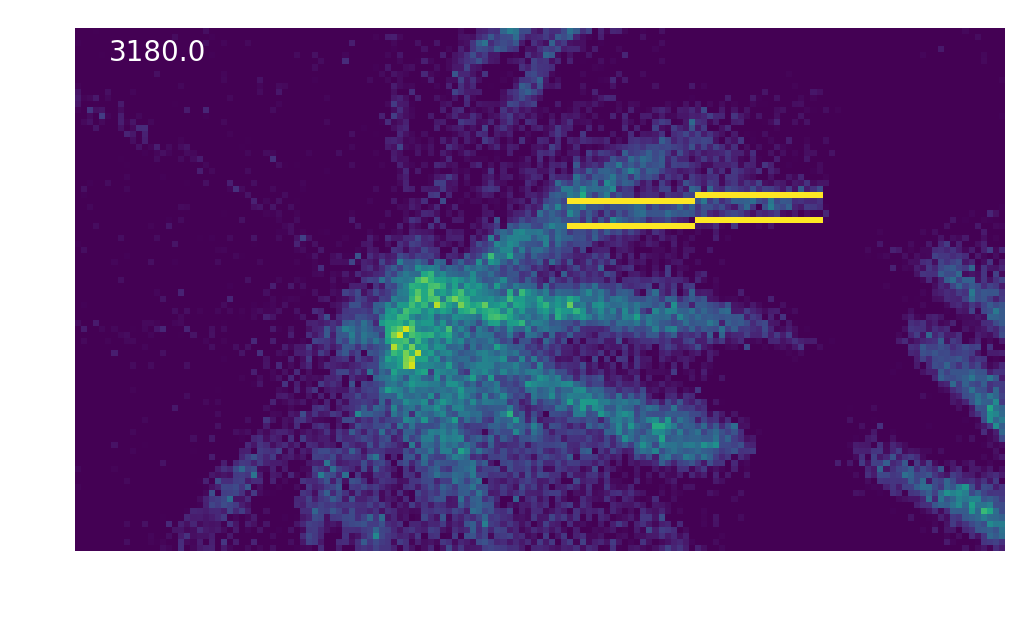

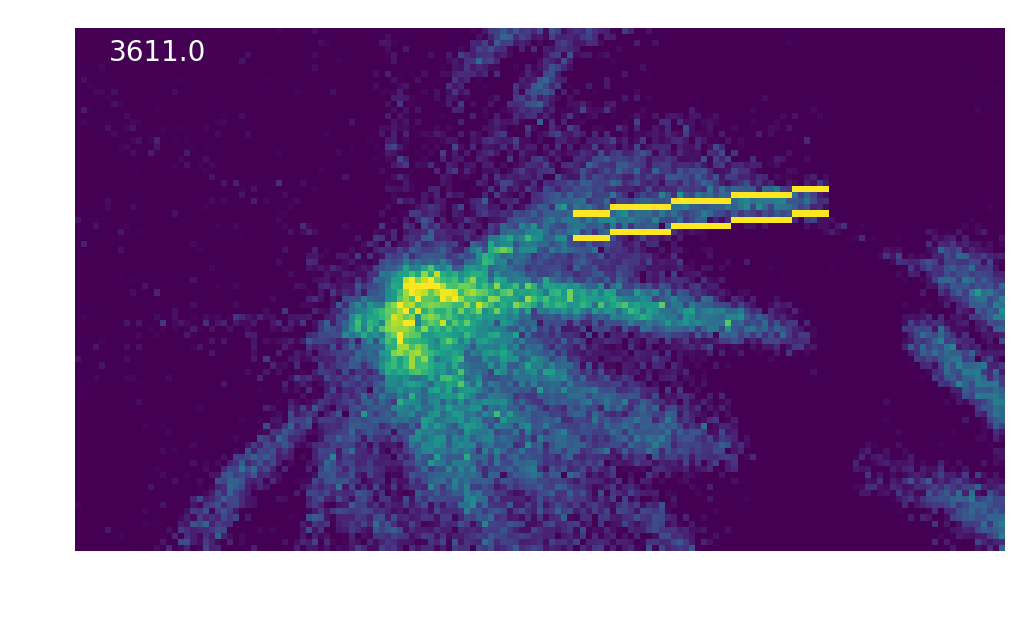

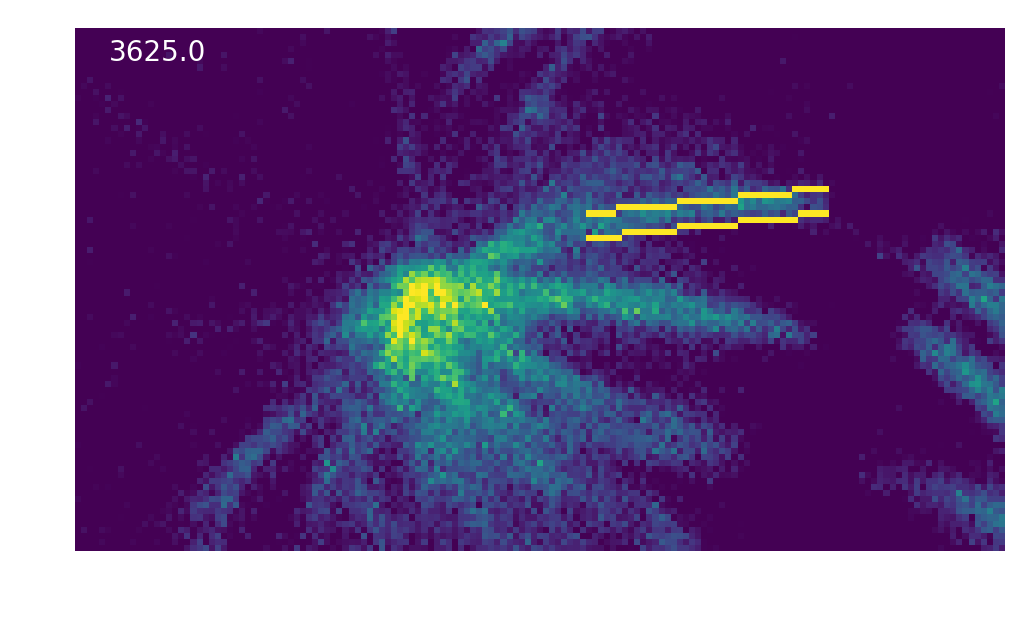

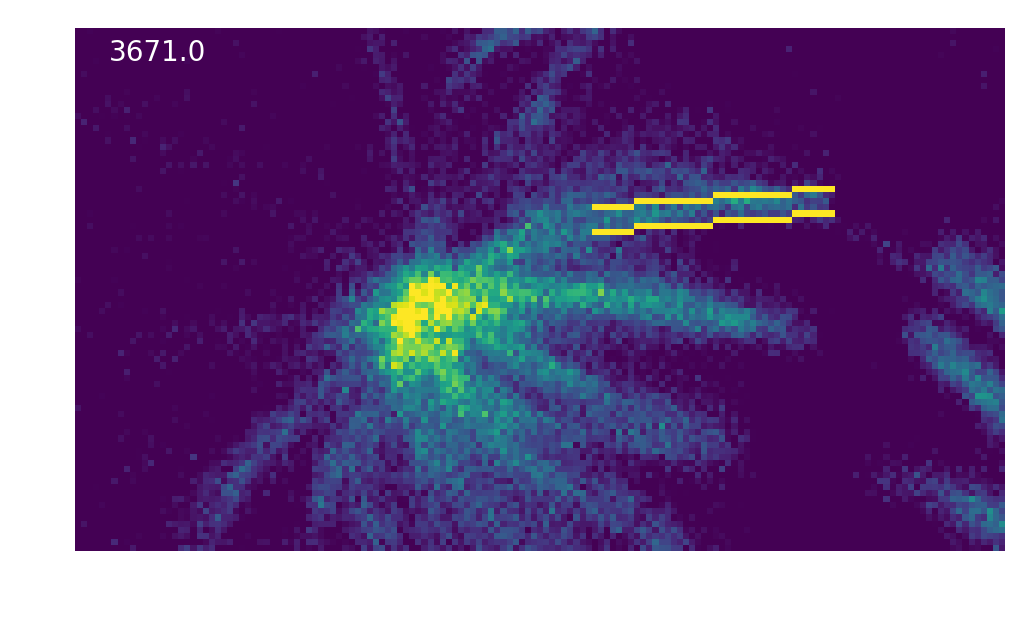

In [22]:
for i in range(len(edgeIms)):
    plt.figure(dpi=200)
    plt.imshow(edgeIms[i])
    plt.axis('off')
    plt.text(5, 5, str(round(avgIs[i])), color='white')

In [104]:
print(len(images), len(times))

32 32
